# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_3511/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_3511/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_3511/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 2.0, "tau_b": 5.0 },  #E[λ_T] = 0.40  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": 1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 30.0 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 15.0 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4408  val=235.6360  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0510  σmin=0.0510  σmax=0.0510


  0%|          | 2/1000 [00:02<24:05,  1.45s/it]

[2/1000] train=232.9660  val=232.7039  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0520  σmin=0.0520  σmax=0.0520


  0%|          | 3/1000 [00:04<21:26,  1.29s/it]

[3/1000] train=226.9969  val=229.7744  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 4/1000 [00:04<18:13,  1.10s/it]

[4/1000] train=222.9202  val=226.8470  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0541  σmin=0.0541  σmax=0.0541


  0%|          | 5/1000 [00:05<16:51,  1.02s/it]

[5/1000] train=222.9363  val=223.9213  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0551  σmin=0.0551  σmax=0.0551


  1%|          | 6/1000 [00:06<15:19,  1.08it/s]

[6/1000] train=223.6535  val=220.9973  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 7/1000 [00:07<14:09,  1.17it/s]

[7/1000] train=217.1070  val=218.0752  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0573  σmin=0.0573  σmax=0.0573


  1%|          | 8/1000 [00:07<13:21,  1.24it/s]

[8/1000] train=217.2452  val=215.1554  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0584  σmin=0.0584  σmax=0.0584


  1%|          | 9/1000 [00:08<13:01,  1.27it/s]

[9/1000] train=214.0112  val=212.2375  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|          | 10/1000 [00:09<12:08,  1.36it/s]

[10/1000] train=207.2018  val=209.3217  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0607  σmin=0.0607  σmax=0.0607


  1%|          | 11/1000 [00:09<12:00,  1.37it/s]

[11/1000] train=211.5465  val=206.4076  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0619  σmin=0.0619  σmax=0.0619


  1%|          | 12/1000 [00:10<11:47,  1.40it/s]

[12/1000] train=207.8093  val=203.4955  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  1%|▏         | 13/1000 [00:11<11:54,  1.38it/s]

[13/1000] train=203.8139  val=200.5850  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0644  σmin=0.0644  σmax=0.0644


  1%|▏         | 14/1000 [00:12<11:55,  1.38it/s]

[14/1000] train=207.6687  val=197.6768  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0656  σmin=0.0656  σmax=0.0656


  2%|▏         | 15/1000 [00:13<14:34,  1.13it/s]

[15/1000] train=196.3216  val=194.7704  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 16/1000 [00:14<13:33,  1.21it/s]

[16/1000] train=193.8935  val=191.8657  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0682  σmin=0.0682  σmax=0.0682


  2%|▏         | 17/1000 [00:14<13:05,  1.25it/s]

[17/1000] train=194.0081  val=188.9628  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0696  σmin=0.0696  σmax=0.0696


  2%|▏         | 18/1000 [00:15<12:36,  1.30it/s]

[18/1000] train=185.4816  val=186.0622  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▏         | 19/1000 [00:16<12:32,  1.30it/s]

[19/1000] train=183.1161  val=183.1639  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0723  σmin=0.0723  σmax=0.0723


  2%|▏         | 20/1000 [00:16<12:18,  1.33it/s]

[20/1000] train=183.0027  val=180.2681  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0737  σmin=0.0737  σmax=0.0737


  2%|▏         | 21/1000 [00:17<13:36,  1.20it/s]

[21/1000] train=180.2710  val=177.3748  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  2%|▏         | 22/1000 [00:19<15:22,  1.06it/s]

[22/1000] train=177.9251  val=174.4835  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0766  σmin=0.0766  σmax=0.0766


  2%|▏         | 23/1000 [00:20<16:26,  1.01s/it]

[23/1000] train=173.5240  val=171.5942  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0781  σmin=0.0781  σmax=0.0781


  2%|▏         | 24/1000 [00:21<16:46,  1.03s/it]

[24/1000] train=168.4628  val=168.7072  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  2%|▎         | 25/1000 [00:22<16:49,  1.04s/it]

[25/1000] train=168.9082  val=165.8228  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0811  σmin=0.0811  σmax=0.0812


  3%|▎         | 26/1000 [00:23<16:51,  1.04s/it]

[26/1000] train=163.9013  val=162.9408  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0827  σmin=0.0827  σmax=0.0827


  3%|▎         | 27/1000 [00:24<16:49,  1.04s/it]

[27/1000] train=161.7870  val=160.0612  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  3%|▎         | 28/1000 [00:25<16:57,  1.05s/it]

[28/1000] train=159.4273  val=157.1841  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0860  σmin=0.0859  σmax=0.0860


  3%|▎         | 29/1000 [00:26<16:56,  1.05s/it]

[29/1000] train=153.3341  val=154.3090  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0876  σmin=0.0876  σmax=0.0876


  3%|▎         | 30/1000 [00:27<17:32,  1.08s/it]

[30/1000] train=155.0589  val=151.4361  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  3%|▎         | 31/1000 [00:29<20:49,  1.29s/it]

[31/1000] train=150.5519  val=148.5655  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0910  σmin=0.0910  σmax=0.0910


  3%|▎         | 32/1000 [00:31<23:17,  1.44s/it]

[32/1000] train=150.1202  val=145.6977  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0928  σmin=0.0928  σmax=0.0928


  3%|▎         | 33/1000 [00:33<24:56,  1.55s/it]

[33/1000] train=145.4183  val=142.8329  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  3%|▎         | 34/1000 [00:35<26:09,  1.62s/it]

[34/1000] train=142.5731  val=139.9711  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0964  σmin=0.0964  σmax=0.0964


  4%|▎         | 35/1000 [00:36<26:58,  1.68s/it]

[35/1000] train=137.7660  val=137.1119  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0983  σmin=0.0982  σmax=0.0983


  4%|▎         | 36/1000 [00:38<27:24,  1.71s/it]

[36/1000] train=138.8658  val=134.2552  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  4%|▎         | 37/1000 [00:40<27:42,  1.73s/it]

[37/1000] train=134.1477  val=131.4009  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1021  σmin=0.1020  σmax=0.1021


  4%|▍         | 38/1000 [00:42<27:42,  1.73s/it]

[38/1000] train=130.1859  val=128.5496  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1040  σmin=0.1040  σmax=0.1040


  4%|▍         | 39/1000 [00:44<30:56,  1.93s/it]

[39/1000] train=128.7395  val=125.7011  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  4%|▍         | 40/1000 [00:46<30:18,  1.89s/it]

[40/1000] train=125.0287  val=122.8558  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1081  σmin=0.1080  σmax=0.1081


  4%|▍         | 41/1000 [00:48<30:06,  1.88s/it]

[41/1000] train=123.4803  val=120.0141  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1101  σmin=0.1101  σmax=0.1101


  4%|▍         | 42/1000 [00:49<29:40,  1.86s/it]

[42/1000] train=119.2495  val=117.1757  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1122  σmin=0.1122  σmax=0.1122


  4%|▍         | 43/1000 [00:51<29:38,  1.86s/it]

[43/1000] train=116.7967  val=114.3401  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1144  σmin=0.1143  σmax=0.1144


  4%|▍         | 44/1000 [00:53<29:21,  1.84s/it]

[44/1000] train=113.0408  val=111.5074  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1165  σmin=0.1165  σmax=0.1166


  4%|▍         | 45/1000 [00:55<29:03,  1.83s/it]

[45/1000] train=110.9290  val=108.6768  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  5%|▍         | 46/1000 [00:57<28:48,  1.81s/it]

[46/1000] train=109.4592  val=105.8487  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1210  σmin=0.1209  σmax=0.1210


  5%|▍         | 47/1000 [00:58<28:42,  1.81s/it]

[47/1000] train=104.8707  val=103.0241  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1233  σmin=0.1232  σmax=0.1233


  5%|▍         | 48/1000 [01:00<29:26,  1.86s/it]

[48/1000] train=103.2085  val=100.2035  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1257  σmin=0.1256  σmax=0.1257


  5%|▍         | 49/1000 [01:02<28:56,  1.83s/it]

[49/1000] train=100.8071  val=97.3867  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1281  σmin=0.1279  σmax=0.1281


  5%|▌         | 50/1000 [01:04<28:27,  1.80s/it]

[50/1000] train=96.9484  val=94.5734  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1305  σmin=0.1303  σmax=0.1305


  5%|▌         | 51/1000 [01:06<28:08,  1.78s/it]

[51/1000] train=95.0045  val=91.7636  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  5%|▌         | 52/1000 [01:07<27:58,  1.77s/it]

[52/1000] train=90.7182  val=88.9572  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1355  σmin=0.1353  σmax=0.1355


  5%|▌         | 53/1000 [01:09<28:50,  1.83s/it]

[53/1000] train=89.3870  val=86.1544  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1380  σmin=0.1378  σmax=0.1380


  5%|▌         | 54/1000 [01:12<32:24,  2.06s/it]

[54/1000] train=86.0113  val=83.3552  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  6%|▌         | 55/1000 [01:14<30:56,  1.96s/it]

[55/1000] train=82.8896  val=80.5600  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1433  σmin=0.1431  σmax=0.1433


  6%|▌         | 56/1000 [01:16<30:03,  1.91s/it]

[56/1000] train=78.6412  val=77.7685  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1460  σmin=0.1457  σmax=0.1460


  6%|▌         | 57/1000 [01:17<29:56,  1.90s/it]

[57/1000] train=75.1306  val=74.9810  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1487  σmin=0.1485  σmax=0.1487


  6%|▌         | 58/1000 [01:19<29:26,  1.88s/it]

[58/1000] train=75.1333  val=72.1973  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1515  σmin=0.1512  σmax=0.1515


  6%|▌         | 59/1000 [01:21<29:28,  1.88s/it]

[59/1000] train=70.8222  val=69.4169  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1543  σmin=0.1541  σmax=0.1543


  6%|▌         | 60/1000 [01:23<29:13,  1.87s/it]

[60/1000] train=69.2376  val=66.6405  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1572  σmin=0.1569  σmax=0.1572


  6%|▌         | 61/1000 [01:25<28:54,  1.85s/it]

[61/1000] train=63.3743  val=63.8687  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1601  σmin=0.1598  σmax=0.1602


  6%|▌         | 62/1000 [01:27<28:36,  1.83s/it]

[62/1000] train=62.2984  val=61.1015  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1631  σmin=0.1628  σmax=0.1631


  6%|▋         | 63/1000 [01:28<28:24,  1.82s/it]

[63/1000] train=59.7932  val=58.3392  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1662  σmin=0.1658  σmax=0.1662


  6%|▋         | 64/1000 [01:30<28:19,  1.82s/it]

[64/1000] train=57.9240  val=55.5807  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1692  σmin=0.1689  σmax=0.1693


  6%|▋         | 65/1000 [01:32<28:00,  1.80s/it]

[65/1000] train=55.6012  val=52.8254  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1724  σmin=0.1720  σmax=0.1724


  7%|▋         | 66/1000 [01:34<28:20,  1.82s/it]

[66/1000] train=52.4944  val=50.0738  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1756  σmin=0.1751  σmax=0.1756


  7%|▋         | 67/1000 [01:35<27:49,  1.79s/it]

[67/1000] train=49.8730  val=47.3274  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1788  σmin=0.1783  σmax=0.1789


  7%|▋         | 68/1000 [01:38<29:44,  1.91s/it]

[68/1000] train=48.0842  val=44.5855  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1821  σmin=0.1816  σmax=0.1822


  7%|▋         | 69/1000 [01:39<29:04,  1.87s/it]

[69/1000] train=42.9152  val=41.8482  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1855  σmin=0.1849  σmax=0.1855


  7%|▋         | 70/1000 [01:41<28:34,  1.84s/it]

[70/1000] train=40.4369  val=39.1156  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1889  σmin=0.1883  σmax=0.1889


  7%|▋         | 71/1000 [01:43<28:10,  1.82s/it]

[71/1000] train=37.5084  val=36.3878  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1924  σmin=0.1917  σmax=0.1924


  7%|▋         | 72/1000 [01:45<27:55,  1.81s/it]

[72/1000] train=37.2724  val=33.6652  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1959  σmin=0.1952  σmax=0.1959


  7%|▋         | 73/1000 [01:47<27:48,  1.80s/it]

[73/1000] train=32.8580  val=30.9488  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1995  σmin=0.1987  σmax=0.1995


  7%|▋         | 74/1000 [01:48<27:43,  1.80s/it]

[74/1000] train=30.7868  val=28.2390  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2031  σmin=0.2023  σmax=0.2032


  8%|▊         | 75/1000 [01:50<27:55,  1.81s/it]

[75/1000] train=28.1868  val=25.5322  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2068  σmin=0.2060  σmax=0.2069


  8%|▊         | 76/1000 [01:52<28:07,  1.83s/it]

[76/1000] train=23.2193  val=22.8310  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2106  σmin=0.2097  σmax=0.2107


  8%|▊         | 77/1000 [01:54<27:49,  1.81s/it]

[77/1000] train=24.0404  val=20.1341  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2144  σmin=0.2134  σmax=0.2145


  8%|▊         | 78/1000 [01:56<27:38,  1.80s/it]

[78/1000] train=20.6812  val=17.4411  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2183  σmin=0.2172  σmax=0.2184


  8%|▊         | 79/1000 [01:57<27:25,  1.79s/it]

[79/1000] train=15.7948  val=14.7511  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2223  σmin=0.2211  σmax=0.2224


  8%|▊         | 80/1000 [01:59<27:51,  1.82s/it]

[80/1000] train=14.4868  val=12.0663  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2263  σmin=0.2251  σmax=0.2264


  8%|▊         | 81/1000 [02:01<27:43,  1.81s/it]

[81/1000] train=10.3769  val=9.3890  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2304  σmin=0.2290  σmax=0.2305


  8%|▊         | 82/1000 [02:03<27:22,  1.79s/it]

[82/1000] train=7.7740  val=6.7189  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2345  σmin=0.2331  σmax=0.2346


  8%|▊         | 83/1000 [02:05<30:47,  2.02s/it]

[83/1000] train=6.8867  val=4.0551  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2387  σmin=0.2372  σmax=0.2388


  8%|▊         | 84/1000 [02:07<31:16,  2.05s/it]

[84/1000] train=2.8983  val=1.3963  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2430  σmin=0.2414  σmax=0.2431


  8%|▊         | 85/1000 [02:10<31:40,  2.08s/it]

[85/1000] train=1.2365  val=-1.2575  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2474  σmin=0.2457  σmax=0.2475


  9%|▊         | 86/1000 [02:11<29:55,  1.96s/it]

[86/1000] train=-3.4340  val=-3.9054  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2518  σmin=0.2500  σmax=0.2519


  9%|▊         | 87/1000 [02:13<28:31,  1.87s/it]

[87/1000] train=-5.4499  val=-6.5467  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2563  σmin=0.2543  σmax=0.2564


  9%|▉         | 88/1000 [02:15<27:39,  1.82s/it]

[88/1000] train=-8.3072  val=-9.1809  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2608  σmin=0.2588  σmax=0.2610


  9%|▉         | 89/1000 [02:16<26:42,  1.76s/it]

[89/1000] train=-8.7352  val=-11.8091  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2655  σmin=0.2633  σmax=0.2656


  9%|▉         | 90/1000 [02:18<25:47,  1.70s/it]

[90/1000] train=-14.0193  val=-14.4314  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2702  σmin=0.2678  σmax=0.2703


  9%|▉         | 91/1000 [02:19<25:27,  1.68s/it]

[91/1000] train=-15.0874  val=-17.0490  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2749  σmin=0.2725  σmax=0.2751


  9%|▉         | 92/1000 [02:21<25:12,  1.67s/it]

[92/1000] train=-17.1787  val=-19.6613  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2798  σmin=0.2772  σmax=0.2799


  9%|▉         | 93/1000 [02:23<24:55,  1.65s/it]

[93/1000] train=-20.6073  val=-22.2668  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2847  σmin=0.2819  σmax=0.2849


  9%|▉         | 94/1000 [02:25<26:34,  1.76s/it]

[94/1000] train=-21.2693  val=-24.8669  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2897  σmin=0.2868  σmax=0.2899


 10%|▉         | 95/1000 [02:27<27:40,  1.83s/it]

[95/1000] train=-26.5878  val=-27.4605  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2947  σmin=0.2916  σmax=0.2950


 10%|▉         | 96/1000 [02:29<31:17,  2.08s/it]

[96/1000] train=-27.3262  val=-30.0489  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2999  σmin=0.2966  σmax=0.3001


 10%|▉         | 97/1000 [02:31<29:15,  1.94s/it]

[97/1000] train=-29.6713  val=-32.6300  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3051  σmin=0.3016  σmax=0.3054


 10%|▉         | 98/1000 [02:33<27:34,  1.83s/it]

[98/1000] train=-33.4475  val=-35.2039  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3104  σmin=0.3067  σmax=0.3107


 10%|▉         | 99/1000 [02:34<26:57,  1.80s/it]

[99/1000] train=-34.5527  val=-37.7706  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3158  σmin=0.3119  σmax=0.3161


 10%|█         | 100/1000 [02:36<27:42,  1.85s/it]

[100/1000] train=-38.2658  val=-40.3288  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3212  σmin=0.3171  σmax=0.3215


 10%|█         | 101/1000 [02:38<26:46,  1.79s/it]

[101/1000] train=-41.1257  val=-42.8786  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3268  σmin=0.3225  σmax=0.3271


 10%|█         | 102/1000 [02:40<26:07,  1.75s/it]

[102/1000] train=-42.7637  val=-45.4191  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3324  σmin=0.3278  σmax=0.3327


 10%|█         | 103/1000 [02:41<25:54,  1.73s/it]

[103/1000] train=-46.0471  val=-47.9532  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3381  σmin=0.3332  σmax=0.3384


 10%|█         | 104/1000 [02:43<25:07,  1.68s/it]

[104/1000] train=-47.4730  val=-50.4822  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3439  σmin=0.3387  σmax=0.3442


 10%|█         | 105/1000 [02:44<24:26,  1.64s/it]

[105/1000] train=-52.0464  val=-53.0045  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3497  σmin=0.3443  σmax=0.3501


 11%|█         | 106/1000 [02:46<23:59,  1.61s/it]

[106/1000] train=-54.5841  val=-55.5190  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3557  σmin=0.3499  σmax=0.3561


 11%|█         | 107/1000 [02:47<23:29,  1.58s/it]

[107/1000] train=-55.8214  val=-58.0246  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3617  σmin=0.3556  σmax=0.3621


 11%|█         | 108/1000 [02:49<23:18,  1.57s/it]

[108/1000] train=-59.6722  val=-60.5222  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3678  σmin=0.3614  σmax=0.3683


 11%|█         | 109/1000 [02:51<23:19,  1.57s/it]

[109/1000] train=-61.2123  val=-63.0131  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3740  σmin=0.3672  σmax=0.3745


 11%|█         | 110/1000 [02:52<23:54,  1.61s/it]

[110/1000] train=-62.8894  val=-65.4947  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3803  σmin=0.3731  σmax=0.3808


 11%|█         | 111/1000 [02:54<23:40,  1.60s/it]

[111/1000] train=-64.9249  val=-67.9673  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3866  σmin=0.3791  σmax=0.3872


 11%|█         | 112/1000 [02:56<25:18,  1.71s/it]

[112/1000] train=-68.0995  val=-70.4297  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3931  σmin=0.3851  σmax=0.3937


 11%|█▏        | 113/1000 [02:57<24:51,  1.68s/it]

[113/1000] train=-70.5159  val=-72.8869  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3996  σmin=0.3912  σmax=0.4002


 11%|█▏        | 114/1000 [02:59<24:21,  1.65s/it]

[114/1000] train=-72.7108  val=-75.3356  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4063  σmin=0.3974  σmax=0.4069


 12%|█▏        | 115/1000 [03:01<26:11,  1.78s/it]

[115/1000] train=-76.7051  val=-77.7764  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4130  σmin=0.4037  σmax=0.4137


 12%|█▏        | 116/1000 [03:03<26:19,  1.79s/it]

[116/1000] train=-77.5517  val=-80.2071  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4198  σmin=0.4101  σmax=0.4205


 12%|█▏        | 117/1000 [03:04<25:18,  1.72s/it]

[117/1000] train=-80.7698  val=-82.6298  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4267  σmin=0.4165  σmax=0.4275


 12%|█▏        | 118/1000 [03:06<24:31,  1.67s/it]

[118/1000] train=-82.8185  val=-85.0487  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4337  σmin=0.4230  σmax=0.4345


 12%|█▏        | 119/1000 [03:07<23:47,  1.62s/it]

[119/1000] train=-86.0379  val=-87.4588  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4408  σmin=0.4296  σmax=0.4416


 12%|█▏        | 120/1000 [03:09<24:07,  1.64s/it]

[120/1000] train=-88.6776  val=-89.8630  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4480  σmin=0.4363  σmax=0.4488


 12%|█▏        | 121/1000 [03:11<23:35,  1.61s/it]

[121/1000] train=-91.5077  val=-92.2611  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4552  σmin=0.4430  σmax=0.4561


 12%|█▏        | 122/1000 [03:12<24:01,  1.64s/it]

[122/1000] train=-93.3844  val=-94.6503  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4626  σmin=0.4498  σmax=0.4635


 12%|█▏        | 123/1000 [03:14<23:34,  1.61s/it]

[123/1000] train=-94.5734  val=-97.0280  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4700  σmin=0.4566  σmax=0.4710


 12%|█▏        | 124/1000 [03:16<23:18,  1.60s/it]

[124/1000] train=-98.6663  val=-99.3979  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4776  σmin=0.4635  σmax=0.4786


 12%|█▎        | 125/1000 [03:17<24:52,  1.71s/it]

[125/1000] train=-100.2954  val=-101.7592  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4852  σmin=0.4705  σmax=0.4863


 13%|█▎        | 126/1000 [03:19<23:57,  1.64s/it]

[126/1000] train=-101.9054  val=-104.1094  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4929  σmin=0.4775  σmax=0.4941


 13%|█▎        | 127/1000 [03:21<24:33,  1.69s/it]

[127/1000] train=-105.4954  val=-106.4479  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5008  σmin=0.4845  σmax=0.5020


 13%|█▎        | 128/1000 [03:22<24:42,  1.70s/it]

[128/1000] train=-106.9209  val=-108.7766  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5087  σmin=0.4915  σmax=0.5100


 13%|█▎        | 129/1000 [03:24<24:40,  1.70s/it]

[129/1000] train=-108.6469  val=-111.0976  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5167  σmin=0.4987  σmax=0.5181


 13%|█▎        | 130/1000 [03:26<24:18,  1.68s/it]

[130/1000] train=-111.6766  val=-113.4071  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5248  σmin=0.5059  σmax=0.5263


 13%|█▎        | 131/1000 [03:28<25:17,  1.75s/it]

[131/1000] train=-116.2227  val=-115.7038  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5330  σmin=0.5133  σmax=0.5346


 13%|█▎        | 132/1000 [03:29<25:00,  1.73s/it]

[132/1000] train=-115.6154  val=-117.9918  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5413  σmin=0.5205  σmax=0.5429


 13%|█▎        | 133/1000 [03:31<25:20,  1.75s/it]

[133/1000] train=-120.7371  val=-120.2657  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5497  σmin=0.5278  σmax=0.5514


 13%|█▎        | 134/1000 [03:33<26:11,  1.82s/it]

[134/1000] train=-120.1735  val=-122.5219  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5582  σmin=0.5352  σmax=0.5600


 14%|█▎        | 135/1000 [03:35<24:52,  1.73s/it]

[135/1000] train=-120.9692  val=-124.7693  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5668  σmin=0.5426  σmax=0.5687


 14%|█▎        | 136/1000 [03:37<25:57,  1.80s/it]

[136/1000] train=-124.2485  val=-126.9883  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5755  σmin=0.5501  σmax=0.5775


 14%|█▎        | 137/1000 [03:38<24:35,  1.71s/it]

[137/1000] train=-126.4968  val=-129.1927  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5843  σmin=0.5576  σmax=0.5864


 14%|█▍        | 138/1000 [03:40<23:39,  1.65s/it]

[138/1000] train=-131.2677  val=-131.3835  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5932  σmin=0.5652  σmax=0.5954


 14%|█▍        | 139/1000 [03:41<23:03,  1.61s/it]

[139/1000] train=-131.2414  val=-133.5778  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6022  σmin=0.5726  σmax=0.6045


 14%|█▍        | 140/1000 [03:43<22:31,  1.57s/it]

[140/1000] train=-135.2972  val=-135.7780  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6112  σmin=0.5801  σmax=0.6137


 14%|█▍        | 141/1000 [03:44<22:39,  1.58s/it]

[141/1000] train=-136.4057  val=-137.9866  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6204  σmin=0.5877  σmax=0.6230


 14%|█▍        | 142/1000 [03:46<22:21,  1.56s/it]

[142/1000] train=-138.3139  val=-140.1847  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6297  σmin=0.5954  σmax=0.6324


 14%|█▍        | 143/1000 [03:47<22:05,  1.55s/it]

[143/1000] train=-139.4472  val=-142.3732  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6391  σmin=0.6032  σmax=0.6419


 14%|█▍        | 144/1000 [03:49<21:50,  1.53s/it]

[144/1000] train=-144.1922  val=-144.5567  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6485  σmin=0.6110  σmax=0.6515


 14%|█▍        | 145/1000 [03:50<21:59,  1.54s/it]

[145/1000] train=-147.1331  val=-146.7188  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6581  σmin=0.6188  σmax=0.6613


 15%|█▍        | 146/1000 [03:52<21:48,  1.53s/it]

[146/1000] train=-146.7043  val=-148.8714  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6678  σmin=0.6265  σmax=0.6711


 15%|█▍        | 147/1000 [03:53<21:46,  1.53s/it]

[147/1000] train=-148.6022  val=-151.0073  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6776  σmin=0.6341  σmax=0.6810


 15%|█▍        | 148/1000 [03:55<21:38,  1.52s/it]

[148/1000] train=-151.7644  val=-153.1353  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6874  σmin=0.6416  σmax=0.6911


 15%|█▍        | 149/1000 [03:56<21:32,  1.52s/it]

[149/1000] train=-153.8762  val=-155.2486  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6974  σmin=0.6492  σmax=0.7012


 15%|█▌        | 150/1000 [03:58<21:48,  1.54s/it]

[150/1000] train=-155.0267  val=-157.3471  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7075  σmin=0.6569  σmax=0.7115


 15%|█▌        | 151/1000 [04:00<21:58,  1.55s/it]

[151/1000] train=-157.0901  val=-159.4359  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7177  σmin=0.6646  σmax=0.7219


 15%|█▌        | 152/1000 [04:02<23:44,  1.68s/it]

[152/1000] train=-159.6060  val=-161.5011  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7279  σmin=0.6721  σmax=0.7324


 15%|█▌        | 153/1000 [04:03<22:55,  1.62s/it]

[153/1000] train=-164.0355  val=-163.5520  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7383  σmin=0.6795  σmax=0.7430


 15%|█▌        | 154/1000 [04:05<22:26,  1.59s/it]

[154/1000] train=-166.0831  val=-165.5906  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7487  σmin=0.6870  σmax=0.7537


 16%|█▌        | 155/1000 [04:06<22:03,  1.57s/it]

[155/1000] train=-164.7538  val=-167.6149  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7593  σmin=0.6946  σmax=0.7645


 16%|█▌        | 156/1000 [04:08<21:46,  1.55s/it]

[156/1000] train=-168.7279  val=-169.6230  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7699  σmin=0.7021  σmax=0.7754


 16%|█▌        | 157/1000 [04:09<22:04,  1.57s/it]

[157/1000] train=-170.1275  val=-171.6141  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7806  σmin=0.7097  σmax=0.7865


 16%|█▌        | 158/1000 [04:11<21:46,  1.55s/it]

[158/1000] train=-171.2856  val=-173.5962  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7914  σmin=0.7175  σmax=0.7976


 16%|█▌        | 159/1000 [04:12<22:22,  1.60s/it]

[159/1000] train=-173.8569  val=-175.5613  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8023  σmin=0.7251  σmax=0.8088


 16%|█▌        | 160/1000 [04:14<22:03,  1.58s/it]

[160/1000] train=-176.3073  val=-177.5261  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8133  σmin=0.7324  σmax=0.8202


 16%|█▌        | 161/1000 [04:15<21:47,  1.56s/it]

[161/1000] train=-175.7439  val=-179.4804  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8244  σmin=0.7397  σmax=0.8316


 16%|█▌        | 162/1000 [04:17<21:30,  1.54s/it]

[162/1000] train=-179.0471  val=-181.4118  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8356  σmin=0.7466  σmax=0.8431


 16%|█▋        | 163/1000 [04:19<21:27,  1.54s/it]

[163/1000] train=-179.7914  val=-183.3358  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8469  σmin=0.7535  σmax=0.8548


 16%|█▋        | 164/1000 [04:21<23:21,  1.68s/it]

[164/1000] train=-185.3808  val=-185.2293  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8582  σmin=0.7601  σmax=0.8666


 16%|█▋        | 165/1000 [04:22<22:38,  1.63s/it]

[165/1000] train=-185.7743  val=-187.1299  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8697  σmin=0.7666  σmax=0.8786


 17%|█▋        | 166/1000 [04:24<22:05,  1.59s/it]

[166/1000] train=-187.2414  val=-188.9988  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8812  σmin=0.7737  σmax=0.8908


 17%|█▋        | 167/1000 [04:25<21:43,  1.56s/it]

[167/1000] train=-191.0656  val=-190.8582  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8929  σmin=0.7805  σmax=0.9030


 17%|█▋        | 168/1000 [04:27<21:24,  1.54s/it]

[168/1000] train=-190.7182  val=-192.6962  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9045  σmin=0.7858  σmax=0.9153


 17%|█▋        | 169/1000 [04:28<21:32,  1.56s/it]

[169/1000] train=-195.0866  val=-194.5392  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9162  σmin=0.7912  σmax=0.9278


 17%|█▋        | 170/1000 [04:30<21:17,  1.54s/it]

[170/1000] train=-197.1028  val=-196.3852  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9280  σmin=0.7967  σmax=0.9403


 17%|█▋        | 171/1000 [04:31<21:08,  1.53s/it]

[171/1000] train=-196.9290  val=-198.2269  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9400  σmin=0.8026  σmax=0.9528


 17%|█▋        | 172/1000 [04:33<21:02,  1.53s/it]

[172/1000] train=-199.5335  val=-200.0398  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9520  σmin=0.8085  σmax=0.9657


 17%|█▋        | 173/1000 [04:34<20:55,  1.52s/it]

[173/1000] train=-201.8096  val=-201.8577  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9640  σmin=0.8141  σmax=0.9785


 17%|█▋        | 174/1000 [04:36<21:02,  1.53s/it]

[174/1000] train=-202.8770  val=-203.6557  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9761  σmin=0.8191  σmax=0.9915


 18%|█▊        | 175/1000 [04:37<20:48,  1.51s/it]

[175/1000] train=-203.4174  val=-205.4246  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9883  σmin=0.8251  σmax=1.0045


 18%|█▊        | 176/1000 [04:39<20:38,  1.50s/it]

[176/1000] train=-205.5206  val=-207.1675  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0005  σmin=0.8319  σmax=1.0176


 18%|█▊        | 177/1000 [04:40<20:36,  1.50s/it]

[177/1000] train=-209.6496  val=-208.8825  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0128  σmin=0.8365  σmax=1.0306


 18%|█▊        | 178/1000 [04:42<20:57,  1.53s/it]

[178/1000] train=-209.5443  val=-210.5913  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0250  σmin=0.8400  σmax=1.0435


 18%|█▊        | 179/1000 [04:44<22:47,  1.67s/it]

[179/1000] train=-208.9660  val=-212.2944  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0374  σmin=0.8431  σmax=1.0565


 18%|█▊        | 180/1000 [04:45<22:05,  1.62s/it]

[180/1000] train=-213.3790  val=-213.9563  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0498  σmin=0.8456  σmax=1.0692


 18%|█▊        | 181/1000 [04:47<21:41,  1.59s/it]

[181/1000] train=-212.6694  val=-215.6080  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0623  σmin=0.8479  σmax=1.0822


 18%|█▊        | 182/1000 [04:48<21:29,  1.58s/it]

[182/1000] train=-215.5637  val=-217.2223  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0746  σmin=0.8503  σmax=1.0954


 18%|█▊        | 183/1000 [04:50<21:13,  1.56s/it]

[183/1000] train=-216.5166  val=-218.7931  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0870  σmin=0.8528  σmax=1.1089


 18%|█▊        | 184/1000 [04:51<21:12,  1.56s/it]

[184/1000] train=-219.3387  val=-220.3704  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0992  σmin=0.8575  σmax=1.1222


 18%|█▊        | 185/1000 [04:53<20:55,  1.54s/it]

[185/1000] train=-219.7466  val=-221.8699  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1114  σmin=0.8642  σmax=1.1355


 19%|█▊        | 186/1000 [04:54<20:44,  1.53s/it]

[186/1000] train=-222.0694  val=-223.2822  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1235  σmin=0.8712  σmax=1.1487


 19%|█▊        | 187/1000 [04:56<21:02,  1.55s/it]

[187/1000] train=-221.7271  val=-224.6998  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1356  σmin=0.8730  σmax=1.1620


 19%|█▉        | 188/1000 [04:57<20:48,  1.54s/it]

[188/1000] train=-225.1619  val=-226.0904  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1478  σmin=0.8745  σmax=1.1754


 19%|█▉        | 189/1000 [04:59<21:06,  1.56s/it]

[189/1000] train=-225.4180  val=-227.4962  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1600  σmin=0.8793  σmax=1.1888


 19%|█▉        | 190/1000 [05:01<20:59,  1.56s/it]

[190/1000] train=-229.1888  val=-228.8594  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1724  σmin=0.8831  σmax=1.2023


 19%|█▉        | 191/1000 [05:02<20:44,  1.54s/it]

[191/1000] train=-227.5441  val=-230.2981  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1849  σmin=0.8879  σmax=1.2159


 19%|█▉        | 192/1000 [05:04<20:32,  1.53s/it]

[192/1000] train=-231.4869  val=-231.6286  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1975  σmin=0.8920  σmax=1.2298


 19%|█▉        | 193/1000 [05:05<20:32,  1.53s/it]

[193/1000] train=-230.8418  val=-232.9943  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2098  σmin=0.8968  σmax=1.2436


 19%|█▉        | 194/1000 [05:07<22:21,  1.66s/it]

[194/1000] train=-233.1560  val=-234.3765  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2220  σmin=0.9024  σmax=1.2572


 20%|█▉        | 195/1000 [05:09<22:52,  1.71s/it]

[195/1000] train=-231.5202  val=-235.6851  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2343  σmin=0.9091  σmax=1.2710


 20%|█▉        | 196/1000 [05:11<22:29,  1.68s/it]

[196/1000] train=-236.6268  val=-236.9095  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2462  σmin=0.9201  σmax=1.2842


 20%|█▉        | 197/1000 [05:12<22:03,  1.65s/it]

[197/1000] train=-236.2711  val=-238.1920  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2582  σmin=0.9204  σmax=1.2978


 20%|█▉        | 198/1000 [05:14<21:29,  1.61s/it]

[198/1000] train=-237.3290  val=-239.3880  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2702  σmin=0.9207  σmax=1.3114


 20%|█▉        | 199/1000 [05:15<21:02,  1.58s/it]

[199/1000] train=-239.3442  val=-240.4909  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2823  σmin=0.9211  σmax=1.3251


 20%|██        | 200/1000 [05:17<20:42,  1.55s/it]

[200/1000] train=-243.0846  val=-241.6326  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2943  σmin=0.9215  σmax=1.3389


 20%|██        | 201/1000 [05:18<20:26,  1.54s/it]

[201/1000] train=-238.8321  val=-242.7486  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3062  σmin=0.9237  σmax=1.3526


 20%|██        | 202/1000 [05:20<20:18,  1.53s/it]

[202/1000] train=-243.8140  val=-243.8534  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3177  σmin=0.9252  σmax=1.3660


 20%|██        | 203/1000 [05:21<20:10,  1.52s/it]

[203/1000] train=-243.1056  val=-244.8572  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3285  σmin=0.9260  σmax=1.3785


 20%|██        | 204/1000 [05:23<20:02,  1.51s/it]

[204/1000] train=-246.1736  val=-245.8639  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3393  σmin=0.9268  σmax=1.3910


 20%|██        | 205/1000 [05:24<20:00,  1.51s/it]

[205/1000] train=-250.1947  val=-246.9191  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3501  σmin=0.9241  σmax=1.4038


 21%|██        | 206/1000 [05:26<20:20,  1.54s/it]

[206/1000] train=-248.2450  val=-247.9000  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3607  σmin=0.9178  σmax=1.4165


 21%|██        | 207/1000 [05:28<21:47,  1.65s/it]

[207/1000] train=-247.0529  val=-248.9393  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3712  σmin=0.9134  σmax=1.4292


 21%|██        | 208/1000 [05:30<25:17,  1.92s/it]

[208/1000] train=-249.4580  val=-250.0057  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3812  σmin=0.9097  σmax=1.4415


 21%|██        | 209/1000 [05:32<24:52,  1.89s/it]

[209/1000] train=-252.2647  val=-251.0099  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3908  σmin=0.9048  σmax=1.4534


 21%|██        | 210/1000 [05:34<24:33,  1.87s/it]

[210/1000] train=-250.7755  val=-251.9411  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4005  σmin=0.9000  σmax=1.4656


 21%|██        | 211/1000 [05:36<24:27,  1.86s/it]

[211/1000] train=-252.7753  val=-252.9388  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4100  σmin=0.8926  σmax=1.4776


 21%|██        | 212/1000 [05:38<25:06,  1.91s/it]

[212/1000] train=-250.4387  val=-253.7282  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4191  σmin=0.8854  σmax=1.4897


 21%|██▏       | 213/1000 [05:39<24:29,  1.87s/it]

[213/1000] train=-251.2722  val=-254.6395  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4283  σmin=0.8806  σmax=1.5020


 21%|██▏       | 214/1000 [05:41<23:46,  1.82s/it]

[214/1000] train=-254.7633  val=-255.5341  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4375  σmin=0.8797  σmax=1.5141


 22%|██▏       | 215/1000 [05:43<23:45,  1.82s/it]

[215/1000] train=-256.3357  val=-256.3312  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4465  σmin=0.8785  σmax=1.5258


 22%|██▏       | 216/1000 [05:45<23:41,  1.81s/it]

[216/1000] train=-253.9122  val=-257.1614  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4553  σmin=0.8825  σmax=1.5375


 22%|██▏       | 217/1000 [05:46<23:03,  1.77s/it]

[217/1000] train=-257.5235  val=-258.0158  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4641  σmin=0.8820  σmax=1.5490


 22%|██▏       | 218/1000 [05:48<23:52,  1.83s/it]

[218/1000] train=-256.4227  val=-258.8880  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4724  σmin=0.8825  σmax=1.5601


 22%|██▏       | 219/1000 [05:50<22:44,  1.75s/it]

[219/1000] train=-257.5889  val=-259.5578  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4803  σmin=0.8851  σmax=1.5707


 22%|██▏       | 220/1000 [05:52<22:04,  1.70s/it]

[220/1000] train=-255.4570  val=-260.2884  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4878  σmin=0.8909  σmax=1.5810


 22%|██▏       | 221/1000 [05:53<21:18,  1.64s/it]

[221/1000] train=-260.6625  val=-260.9049  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4956  σmin=0.8948  σmax=1.5917


 22%|██▏       | 222/1000 [05:55<20:50,  1.61s/it]

[222/1000] train=-256.6405  val=-261.5113  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5029  σmin=0.8956  σmax=1.6037


 22%|██▏       | 223/1000 [05:56<20:27,  1.58s/it]

[223/1000] train=-262.2105  val=-262.1007  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5102  σmin=0.8963  σmax=1.6131


 22%|██▏       | 224/1000 [05:58<20:35,  1.59s/it]

[224/1000] train=-260.1922  val=-262.5716  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5175  σmin=0.8959  σmax=1.6223


 22%|██▎       | 225/1000 [05:59<20:34,  1.59s/it]

[225/1000] train=-260.9215  val=-263.0519  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5245  σmin=0.8975  σmax=1.6310


 23%|██▎       | 226/1000 [06:01<20:22,  1.58s/it]

[226/1000] train=-261.8570  val=-263.4095  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5310  σmin=0.8996  σmax=1.6398


 23%|██▎       | 227/1000 [06:02<20:05,  1.56s/it]

[227/1000] train=-261.3013  val=-263.7496  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5372  σmin=0.9042  σmax=1.6482


 23%|██▎       | 228/1000 [06:04<19:54,  1.55s/it]

[228/1000] train=-263.5532  val=-264.1400  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5434  σmin=0.9034  σmax=1.6567


 23%|██▎       | 229/1000 [06:05<19:47,  1.54s/it]

[229/1000] train=-263.4613  val=-264.2826  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5500  σmin=0.9017  σmax=1.6659


 23%|██▎       | 230/1000 [06:07<19:44,  1.54s/it]

[230/1000] train=-264.7201  val=-264.6048  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5565  σmin=0.8981  σmax=1.6748


 23%|██▎       | 231/1000 [06:09<19:50,  1.55s/it]

[231/1000] train=-263.2196  val=-264.8766  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5625  σmin=0.8923  σmax=1.6831


 23%|██▎       | 232/1000 [06:10<20:13,  1.58s/it]

[232/1000] train=-266.6521  val=-265.0248  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5683  σmin=0.8819  σmax=1.6911


 23%|██▎       | 233/1000 [06:12<21:59,  1.72s/it]

[233/1000] train=-265.2457  val=-265.2180  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5740  σmin=0.8773  σmax=1.6993


 23%|██▎       | 234/1000 [06:14<21:54,  1.72s/it]

[234/1000] train=-262.8620  val=-265.4724  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5794  σmin=0.8749  σmax=1.7106


 24%|██▎       | 235/1000 [06:16<21:24,  1.68s/it]

[235/1000] train=-266.6620  val=-265.8752  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5848  σmin=0.8739  σmax=1.7226


 24%|██▎       | 236/1000 [06:17<20:44,  1.63s/it]

[236/1000] train=-266.0747  val=-266.2546  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5901  σmin=0.8718  σmax=1.7341


 24%|██▎       | 237/1000 [06:19<20:18,  1.60s/it]

[237/1000] train=-268.6692  val=-266.6089  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5954  σmin=0.8676  σmax=1.7445


 24%|██▍       | 238/1000 [06:20<19:58,  1.57s/it]

[238/1000] train=-267.5971  val=-266.7827  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6004  σmin=0.8601  σmax=1.7539


 24%|██▍       | 239/1000 [06:22<19:52,  1.57s/it]

[239/1000] train=-263.2206  val=-267.0927  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6051  σmin=0.8547  σmax=1.7619


 24%|██▍       | 240/1000 [06:23<19:41,  1.55s/it]

[240/1000] train=-270.3950  val=-267.3053  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6100  σmin=0.8500  σmax=1.7705


 24%|██▍       | 241/1000 [06:25<19:35,  1.55s/it]

[241/1000] train=-269.3103  val=-267.6721  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6146  σmin=0.8464  σmax=1.7787


 24%|██▍       | 242/1000 [06:26<19:21,  1.53s/it]

[242/1000] train=-269.5904  val=-268.0594  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6193  σmin=0.8437  σmax=1.7869


 24%|██▍       | 243/1000 [06:28<19:35,  1.55s/it]

[243/1000] train=-268.3911  val=-268.4734  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6242  σmin=0.8430  σmax=1.7940


 24%|██▍       | 244/1000 [06:29<19:33,  1.55s/it]

[244/1000] train=-266.0014  val=-268.9732  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6288  σmin=0.8394  σmax=1.8011


 24%|██▍       | 245/1000 [06:31<19:18,  1.53s/it]

[245/1000] train=-268.7104  val=-269.4100  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6332  σmin=0.8417  σmax=1.8078


 25%|██▍       | 246/1000 [06:32<19:10,  1.53s/it]

[246/1000] train=-265.7901  val=-269.7205  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6374  σmin=0.8429  σmax=1.8150


 25%|██▍       | 247/1000 [06:34<19:06,  1.52s/it]

[247/1000] train=-268.7789  val=-270.0707  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6416  σmin=0.8447  σmax=1.8219


 25%|██▍       | 248/1000 [06:36<20:51,  1.66s/it]

[248/1000] train=-270.5264  val=-270.4600  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6458  σmin=0.8429  σmax=1.8290


 25%|██▍       | 249/1000 [06:37<20:18,  1.62s/it]

[249/1000] train=-272.3027  val=-270.7836  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6501  σmin=0.8471  σmax=1.8360


 25%|██▌       | 250/1000 [06:39<19:53,  1.59s/it]

[250/1000] train=-273.0637  val=-271.1817  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6545  σmin=0.8517  σmax=1.8433


 25%|██▌       | 251/1000 [06:40<19:32,  1.57s/it]

[251/1000] train=-273.7109  val=-271.5932  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6589  σmin=0.8572  σmax=1.8505


 25%|██▌       | 252/1000 [06:42<19:39,  1.58s/it]

[252/1000] train=-269.5140  val=-272.0464  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6634  σmin=0.8611  σmax=1.8576


 25%|██▌       | 253/1000 [06:44<19:21,  1.56s/it]

[253/1000] train=-271.1973  val=-272.5413  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6681  σmin=0.8661  σmax=1.8642


 25%|██▌       | 254/1000 [06:45<19:06,  1.54s/it]

[254/1000] train=-269.4195  val=-273.1414  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6727  σmin=0.8711  σmax=1.8697


 26%|██▌       | 255/1000 [06:47<18:55,  1.52s/it]

[255/1000] train=-274.6372  val=-273.6475  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6771  σmin=0.8685  σmax=1.8746


 26%|██▌       | 256/1000 [06:48<18:48,  1.52s/it]

[256/1000] train=-277.1035  val=-274.3012  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6816  σmin=0.8643  σmax=1.8797


 26%|██▌       | 257/1000 [06:50<18:44,  1.51s/it]

[257/1000] train=-274.0051  val=-274.8827  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6866  σmin=0.8620  σmax=1.8853


 26%|██▌       | 258/1000 [06:51<18:54,  1.53s/it]

[258/1000] train=-276.2085  val=-275.3965  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6914  σmin=0.8596  σmax=1.8915


 26%|██▌       | 259/1000 [06:53<18:48,  1.52s/it]

[259/1000] train=-274.1132  val=-275.9576  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6961  σmin=0.8578  σmax=1.8977


 26%|██▌       | 260/1000 [06:54<18:43,  1.52s/it]

[260/1000] train=-271.3920  val=-276.5281  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7005  σmin=0.8568  σmax=1.9037


 26%|██▌       | 261/1000 [06:56<18:38,  1.51s/it]

[261/1000] train=-276.3149  val=-276.9339  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7049  σmin=0.8559  σmax=1.9095


 26%|██▌       | 262/1000 [06:57<18:58,  1.54s/it]

[262/1000] train=-274.3117  val=-277.2691  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7091  σmin=0.8550  σmax=1.9151


 26%|██▋       | 263/1000 [06:59<19:40,  1.60s/it]

[263/1000] train=-275.6307  val=-277.5751  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7133  σmin=0.8546  σmax=1.9208


 26%|██▋       | 264/1000 [07:01<22:14,  1.81s/it]

[264/1000] train=-276.3348  val=-277.7482  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7176  σmin=0.8520  σmax=1.9270


 26%|██▋       | 265/1000 [07:03<22:20,  1.82s/it]

[265/1000] train=-269.9032  val=-277.9827  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7215  σmin=0.8488  σmax=1.9330


 27%|██▋       | 266/1000 [07:05<22:04,  1.80s/it]

[266/1000] train=-271.2719  val=-278.1833  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7251  σmin=0.8455  σmax=1.9387


 27%|██▋       | 267/1000 [07:07<21:49,  1.79s/it]

[267/1000] train=-278.8028  val=-278.3892  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7286  σmin=0.8407  σmax=1.9443


 27%|██▋       | 268/1000 [07:08<21:40,  1.78s/it]

[268/1000] train=-264.4597  val=-278.5261  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7319  σmin=0.8375  σmax=1.9494


 27%|██▋       | 269/1000 [07:10<22:03,  1.81s/it]

[269/1000] train=-279.0117  val=-278.6935  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7352  σmin=0.8344  σmax=1.9545


 27%|██▋       | 270/1000 [07:12<21:56,  1.80s/it]

[270/1000] train=-278.7821  val=-278.7861  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7389  σmin=0.8331  σmax=1.9600


 27%|██▋       | 271/1000 [07:14<22:03,  1.82s/it]

[271/1000] train=-269.9229  val=-278.8638  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7424  σmin=0.8287  σmax=1.9655


 27%|██▋       | 272/1000 [07:16<21:41,  1.79s/it]

[272/1000] train=-278.4435  val=-279.0570  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7459  σmin=0.8260  σmax=1.9712


 27%|██▋       | 273/1000 [07:17<21:22,  1.76s/it]

[273/1000] train=-280.3456  val=-279.1613  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7492  σmin=0.8236  σmax=1.9766


 27%|██▋       | 274/1000 [07:19<21:10,  1.75s/it]

[274/1000] train=-277.9629  val=-279.2738  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7526  σmin=0.8213  σmax=1.9822


 28%|██▊       | 275/1000 [07:21<21:04,  1.74s/it]

[275/1000] train=-280.6562  val=-279.3891  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7561  σmin=0.8175  σmax=1.9880


 28%|██▊       | 276/1000 [07:22<21:00,  1.74s/it]

[276/1000] train=-265.7787  val=-279.4326  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7593  σmin=0.8147  σmax=1.9935


 28%|██▊       | 277/1000 [07:24<20:56,  1.74s/it]

[277/1000] train=-276.6365  val=-279.5447  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7624  σmin=0.8127  σmax=1.9991


 28%|██▊       | 278/1000 [07:26<20:56,  1.74s/it]

[278/1000] train=-281.1667  val=-279.4569  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7656  σmin=0.8067  σmax=2.0050


 28%|██▊       | 279/1000 [07:28<20:46,  1.73s/it]

[279/1000] train=-272.1600  val=-279.5512  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7688  σmin=0.8017  σmax=2.0105


 28%|██▊       | 280/1000 [07:30<21:09,  1.76s/it]

[280/1000] train=-278.0965  val=-279.6427  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7722  σmin=0.7965  σmax=2.0168


 28%|██▊       | 281/1000 [07:32<22:41,  1.89s/it]

[281/1000] train=-278.3764  val=-279.8790  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7757  σmin=0.7928  σmax=2.0234


 28%|██▊       | 282/1000 [07:33<22:05,  1.85s/it]

[282/1000] train=-279.2994  val=-280.0847  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7792  σmin=0.7872  σmax=2.0311


 28%|██▊       | 283/1000 [07:35<21:48,  1.83s/it]

[283/1000] train=-280.4601  val=-280.2614  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7828  σmin=0.7830  σmax=2.0388


 28%|██▊       | 284/1000 [07:37<21:35,  1.81s/it]

[284/1000] train=-279.7715  val=-280.5153  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7866  σmin=0.7778  σmax=2.0463


 28%|██▊       | 285/1000 [07:39<21:14,  1.78s/it]

[285/1000] train=-279.4551  val=-280.6000  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7902  σmin=0.7714  σmax=2.0536


 29%|██▊       | 286/1000 [07:40<21:00,  1.76s/it]

[286/1000] train=-282.7581  val=-280.7937  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7937  σmin=0.7646  σmax=2.0605


 29%|██▊       | 287/1000 [07:42<20:49,  1.75s/it]

[287/1000] train=-284.1863  val=-280.9820  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7973  σmin=0.7567  σmax=2.0675


 29%|██▉       | 288/1000 [07:44<20:42,  1.74s/it]

[288/1000] train=-282.4465  val=-281.1857  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8010  σmin=0.7466  σmax=2.0745


 29%|██▉       | 289/1000 [07:46<20:55,  1.77s/it]

[289/1000] train=-278.3085  val=-281.2574  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8045  σmin=0.7349  σmax=2.0806


 29%|██▉       | 290/1000 [07:47<20:43,  1.75s/it]

[290/1000] train=-281.7553  val=-281.4262  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8081  σmin=0.7220  σmax=2.0863


 29%|██▉       | 291/1000 [07:49<20:37,  1.75s/it]

[291/1000] train=-282.6397  val=-281.7220  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8116  σmin=0.7117  σmax=2.0915


 29%|██▉       | 292/1000 [07:51<20:42,  1.76s/it]

[292/1000] train=-286.5232  val=-281.8171  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8152  σmin=0.7017  σmax=2.0968


 29%|██▉       | 293/1000 [07:53<20:42,  1.76s/it]

[293/1000] train=-275.9601  val=-281.9126  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8186  σmin=0.6924  σmax=2.1022


 29%|██▉       | 294/1000 [07:54<20:28,  1.74s/it]

[294/1000] train=-286.2609  val=-281.9871  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8220  σmin=0.6835  σmax=2.1075


 30%|██▉       | 295/1000 [07:56<20:23,  1.74s/it]

[295/1000] train=-285.8234  val=-282.1576  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8258  σmin=0.6768  σmax=2.1132


 30%|██▉       | 296/1000 [07:58<20:26,  1.74s/it]

[296/1000] train=-286.5041  val=-282.3287  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8296  σmin=0.6702  σmax=2.1189


 30%|██▉       | 297/1000 [08:00<20:35,  1.76s/it]

[297/1000] train=-285.6750  val=-282.6376  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8333  σmin=0.6630  σmax=2.1246


 30%|██▉       | 298/1000 [08:02<22:20,  1.91s/it]

[298/1000] train=-278.6905  val=-283.0402  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8371  σmin=0.6571  σmax=2.1305


 30%|██▉       | 299/1000 [08:04<22:05,  1.89s/it]

[299/1000] train=-283.1651  val=-283.5959  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8407  σmin=0.6512  σmax=2.1364


 30%|███       | 300/1000 [08:06<21:36,  1.85s/it]

[300/1000] train=-282.4534  val=-283.9552  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8442  σmin=0.6447  σmax=2.1423


 30%|███       | 301/1000 [08:07<21:13,  1.82s/it]

[301/1000] train=-285.1490  val=-284.1997  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8475  σmin=0.6391  σmax=2.1478


 30%|███       | 302/1000 [08:09<21:27,  1.84s/it]

[302/1000] train=-286.4560  val=-284.5220  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8508  σmin=0.6343  σmax=2.1533


 30%|███       | 303/1000 [08:11<21:17,  1.83s/it]

[303/1000] train=-286.3952  val=-284.9342  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8546  σmin=0.6302  σmax=2.1595


 30%|███       | 304/1000 [08:13<21:12,  1.83s/it]

[304/1000] train=-291.3326  val=-285.2790  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8587  σmin=0.6254  σmax=2.1662


 30%|███       | 305/1000 [08:15<20:54,  1.80s/it]

[305/1000] train=-289.8000  val=-285.7257  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8627  σmin=0.6206  σmax=2.1728


 31%|███       | 306/1000 [08:16<20:37,  1.78s/it]

[306/1000] train=-290.6166  val=-286.2512  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8669  σmin=0.6164  σmax=2.1796


 31%|███       | 307/1000 [08:18<20:26,  1.77s/it]

[307/1000] train=-284.2924  val=-286.3496  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8709  σmin=0.6130  σmax=2.1863


 31%|███       | 308/1000 [08:20<20:43,  1.80s/it]

[308/1000] train=-291.8330  val=-286.7252  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8754  σmin=0.6100  σmax=2.1936


 31%|███       | 309/1000 [08:22<20:30,  1.78s/it]

[309/1000] train=-287.0132  val=-286.7920  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8796  σmin=0.6065  σmax=2.2007


 31%|███       | 310/1000 [08:23<20:28,  1.78s/it]

[310/1000] train=-285.8646  val=-287.1140  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8835  σmin=0.6015  σmax=2.2073


 31%|███       | 311/1000 [08:25<20:28,  1.78s/it]

[311/1000] train=-285.7867  val=-287.2871  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8872  σmin=0.5979  σmax=2.2137


 31%|███       | 312/1000 [08:27<20:25,  1.78s/it]

[312/1000] train=-281.6816  val=-287.6457  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8908  σmin=0.5954  σmax=2.2198


 31%|███▏      | 313/1000 [08:29<20:16,  1.77s/it]

[313/1000] train=-290.4920  val=-287.8918  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8945  σmin=0.5928  σmax=2.2259


 31%|███▏      | 314/1000 [08:31<21:47,  1.91s/it]

[314/1000] train=-283.6750  val=-288.1112  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8981  σmin=0.5901  σmax=2.2322


 32%|███▏      | 315/1000 [08:33<21:15,  1.86s/it]

[315/1000] train=-287.2888  val=-288.2754  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9016  σmin=0.5869  σmax=2.2380


 32%|███▏      | 316/1000 [08:34<20:50,  1.83s/it]

[316/1000] train=-285.6761  val=-288.5124  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9048  σmin=0.5841  σmax=2.2437


 32%|███▏      | 317/1000 [08:36<20:58,  1.84s/it]

[317/1000] train=-288.3055  val=-288.7494  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9084  σmin=0.5840  σmax=2.2497


 32%|███▏      | 318/1000 [08:38<20:40,  1.82s/it]

[318/1000] train=-290.3406  val=-289.1348  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9123  σmin=0.5834  σmax=2.2560


 32%|███▏      | 319/1000 [08:40<20:24,  1.80s/it]

[319/1000] train=-291.8759  val=-289.5154  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9162  σmin=0.5842  σmax=2.2626


 32%|███▏      | 320/1000 [08:42<20:09,  1.78s/it]

[320/1000] train=-285.8325  val=-289.8177  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9200  σmin=0.5828  σmax=2.2690


 32%|███▏      | 321/1000 [08:43<19:57,  1.76s/it]

[321/1000] train=-293.8358  val=-290.3837  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9240  σmin=0.5803  σmax=2.2758


 32%|███▏      | 322/1000 [08:45<19:50,  1.76s/it]

[322/1000] train=-288.5502  val=-290.9485  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9278  σmin=0.5772  σmax=2.2824


 32%|███▏      | 323/1000 [08:47<19:51,  1.76s/it]

[323/1000] train=-285.2473  val=-291.5941  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9314  σmin=0.5744  σmax=2.2888


 32%|███▏      | 324/1000 [08:49<19:44,  1.75s/it]

[324/1000] train=-294.3952  val=-292.1578  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9353  σmin=0.5734  σmax=2.2955


 32%|███▎      | 325/1000 [08:50<19:41,  1.75s/it]

[325/1000] train=-294.8446  val=-292.7212  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9394  σmin=0.5718  σmax=2.3025


 33%|███▎      | 326/1000 [08:52<19:57,  1.78s/it]

[326/1000] train=-294.6078  val=-293.0608  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9442  σmin=0.5693  σmax=2.3103


 33%|███▎      | 327/1000 [08:54<20:14,  1.80s/it]

[327/1000] train=-290.4873  val=-293.4534  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9487  σmin=0.5664  σmax=2.3175


 33%|███▎      | 328/1000 [08:56<19:58,  1.78s/it]

[328/1000] train=-289.3669  val=-294.0719  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9530  σmin=0.5639  σmax=2.3245


 33%|███▎      | 329/1000 [08:58<19:50,  1.77s/it]

[329/1000] train=-295.2778  val=-294.5496  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9572  σmin=0.5611  σmax=2.3313


 33%|███▎      | 330/1000 [09:00<21:41,  1.94s/it]

[330/1000] train=-298.5173  val=-294.9503  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9612  σmin=0.5583  σmax=2.3379


 33%|███▎      | 331/1000 [09:02<21:20,  1.91s/it]

[331/1000] train=-293.5359  val=-295.3575  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9652  σmin=0.5556  σmax=2.3444


 33%|███▎      | 332/1000 [09:03<20:46,  1.87s/it]

[332/1000] train=-288.2619  val=-295.6669  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9688  σmin=0.5519  σmax=2.3504


 33%|███▎      | 333/1000 [09:05<20:24,  1.84s/it]

[333/1000] train=-295.5625  val=-295.9272  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9725  σmin=0.5481  σmax=2.3563


 33%|███▎      | 334/1000 [09:07<20:07,  1.81s/it]

[334/1000] train=-297.3493  val=-296.3006  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9763  σmin=0.5447  σmax=2.3625


 34%|███▎      | 335/1000 [09:09<20:22,  1.84s/it]

[335/1000] train=-295.5568  val=-296.6732  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9802  σmin=0.5398  σmax=2.3688


 34%|███▎      | 336/1000 [09:11<20:26,  1.85s/it]

[336/1000] train=-294.2346  val=-297.0183  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9842  σmin=0.5350  σmax=2.3752


 34%|███▎      | 337/1000 [09:13<20:24,  1.85s/it]

[337/1000] train=-292.9584  val=-297.3490  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9878  σmin=0.5299  σmax=2.3812


 34%|███▍      | 338/1000 [09:14<20:00,  1.81s/it]

[338/1000] train=-299.1171  val=-297.7813  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9917  σmin=0.5264  σmax=2.3873


 34%|███▍      | 339/1000 [09:16<19:46,  1.79s/it]

[339/1000] train=-298.8409  val=-298.0511  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9952  σmin=0.5229  σmax=2.3930


 34%|███▍      | 340/1000 [09:18<19:36,  1.78s/it]

[340/1000] train=-296.5208  val=-298.3646  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9989  σmin=0.5203  σmax=2.3990


 34%|███▍      | 341/1000 [09:20<19:27,  1.77s/it]

[341/1000] train=-294.8502  val=-298.5673  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0028  σmin=0.5181  σmax=2.4050


 34%|███▍      | 342/1000 [09:21<19:15,  1.76s/it]

[342/1000] train=-299.2628  val=-298.9156  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0067  σmin=0.5147  σmax=2.4110


 34%|███▍      | 343/1000 [09:23<19:13,  1.76s/it]

[343/1000] train=-301.8329  val=-299.1630  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0112  σmin=0.5114  σmax=2.4176


 34%|███▍      | 344/1000 [09:25<19:10,  1.75s/it]

[344/1000] train=-292.4400  val=-299.2994  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0158  σmin=0.5080  σmax=2.4244


 34%|███▍      | 345/1000 [09:27<21:19,  1.95s/it]

[345/1000] train=-300.5719  val=-299.6596  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0209  σmin=0.5055  σmax=2.4316


 35%|███▍      | 346/1000 [09:29<20:41,  1.90s/it]

[346/1000] train=-293.7490  val=-299.8528  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0255  σmin=0.5028  σmax=2.4386


 35%|███▍      | 347/1000 [09:31<20:08,  1.85s/it]

[347/1000] train=-300.1074  val=-300.1201  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0306  σmin=0.4993  σmax=2.4464


 35%|███▍      | 348/1000 [09:32<19:49,  1.82s/it]

[348/1000] train=-300.2950  val=-300.4282  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0353  σmin=0.4955  σmax=2.4538


 35%|███▍      | 349/1000 [09:34<19:30,  1.80s/it]

[349/1000] train=-291.7862  val=-300.6491  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0398  σmin=0.4927  σmax=2.4610


 35%|███▌      | 350/1000 [09:36<19:19,  1.78s/it]

[350/1000] train=-301.3771  val=-300.9594  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0445  σmin=0.4905  σmax=2.4684


 35%|███▌      | 351/1000 [09:38<19:22,  1.79s/it]

[351/1000] train=-299.7970  val=-301.0614  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0494  σmin=0.4880  σmax=2.4760


 35%|███▌      | 352/1000 [09:40<19:11,  1.78s/it]

[352/1000] train=-296.7257  val=-301.2882  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0542  σmin=0.4852  σmax=2.4836


 35%|███▌      | 353/1000 [09:41<19:03,  1.77s/it]

[353/1000] train=-302.5119  val=-301.4366  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0591  σmin=0.4839  σmax=2.4912


 35%|███▌      | 354/1000 [09:43<19:00,  1.77s/it]

[354/1000] train=-296.2061  val=-301.7350  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0639  σmin=0.4819  σmax=2.4987


 36%|███▌      | 355/1000 [09:45<19:16,  1.79s/it]

[355/1000] train=-301.7071  val=-301.9437  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0686  σmin=0.4805  σmax=2.5059


 36%|███▌      | 356/1000 [09:47<19:01,  1.77s/it]

[356/1000] train=-298.9697  val=-302.2265  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0729  σmin=0.4779  σmax=2.5128


 36%|███▌      | 357/1000 [09:48<18:56,  1.77s/it]

[357/1000] train=-303.6605  val=-302.5090  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0774  σmin=0.4761  σmax=2.5197


 36%|███▌      | 358/1000 [09:50<18:51,  1.76s/it]

[358/1000] train=-304.6519  val=-302.7129  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0819  σmin=0.4736  σmax=2.5267


 36%|███▌      | 359/1000 [09:52<18:57,  1.77s/it]

[359/1000] train=-300.4229  val=-302.8820  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0861  σmin=0.4698  σmax=2.5333


 36%|███▌      | 360/1000 [09:54<18:51,  1.77s/it]

[360/1000] train=-303.5943  val=-303.1335  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0906  σmin=0.4671  σmax=2.5403


 36%|███▌      | 361/1000 [09:56<20:13,  1.90s/it]

[361/1000] train=-304.4066  val=-303.4091  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0952  σmin=0.4632  σmax=2.5473


 36%|███▌      | 362/1000 [09:58<19:43,  1.86s/it]

[362/1000] train=-299.4166  val=-303.4371  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0997  σmin=0.4598  σmax=2.5540


 36%|███▋      | 363/1000 [09:59<19:31,  1.84s/it]

[363/1000] train=-302.4730  val=-303.6382  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1040  σmin=0.4566  σmax=2.5607


 36%|███▋      | 364/1000 [10:01<19:33,  1.85s/it]

[364/1000] train=-302.2139  val=-303.8612  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1082  σmin=0.4545  σmax=2.5671


 36%|███▋      | 365/1000 [10:03<19:17,  1.82s/it]

[365/1000] train=-295.7283  val=-304.0229  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1121  σmin=0.4535  σmax=2.5733


 37%|███▋      | 366/1000 [10:05<19:06,  1.81s/it]

[366/1000] train=-305.3863  val=-304.2479  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1165  σmin=0.4518  σmax=2.5799


 37%|███▋      | 367/1000 [10:07<18:56,  1.80s/it]

[367/1000] train=-303.8284  val=-304.4766  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1208  σmin=0.4507  σmax=2.5866


 37%|███▋      | 368/1000 [10:08<18:51,  1.79s/it]

[368/1000] train=-297.7321  val=-304.7560  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1249  σmin=0.4495  σmax=2.5929


 37%|███▋      | 369/1000 [10:10<19:13,  1.83s/it]

[369/1000] train=-304.0677  val=-304.9453  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1291  σmin=0.4483  σmax=2.5991


 37%|███▋      | 370/1000 [10:12<19:35,  1.87s/it]

[370/1000] train=-303.2319  val=-305.1639  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1328  σmin=0.4470  σmax=2.6049


 37%|███▋      | 371/1000 [10:14<19:12,  1.83s/it]

[371/1000] train=-302.9574  val=-305.4531  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1363  σmin=0.4451  σmax=2.6104


 37%|███▋      | 372/1000 [10:16<18:55,  1.81s/it]

[372/1000] train=-306.3307  val=-305.5819  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1398  σmin=0.4432  σmax=2.6160


 37%|███▋      | 373/1000 [10:18<19:04,  1.83s/it]

[373/1000] train=-303.0380  val=-305.7517  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1430  σmin=0.4408  σmax=2.6214


 37%|███▋      | 374/1000 [10:19<18:49,  1.80s/it]

[374/1000] train=-302.7604  val=-306.0281  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1460  σmin=0.4376  σmax=2.6265


 38%|███▊      | 375/1000 [10:21<18:31,  1.78s/it]

[375/1000] train=-304.7818  val=-306.1813  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1489  σmin=0.4341  σmax=2.6316


 38%|███▊      | 376/1000 [10:24<22:53,  2.20s/it]

[376/1000] train=-305.6485  val=-306.2375  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1516  σmin=0.4305  σmax=2.6366


 38%|███▊      | 377/1000 [10:27<23:31,  2.27s/it]

[377/1000] train=-300.3738  val=-306.4353  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1543  σmin=0.4278  σmax=2.6413


 38%|███▊      | 378/1000 [10:29<25:08,  2.42s/it]

[378/1000] train=-309.1566  val=-306.5815  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1571  σmin=0.4250  σmax=2.6461


 38%|███▊      | 379/1000 [10:32<24:35,  2.38s/it]

[379/1000] train=-305.3007  val=-306.7234  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1600  σmin=0.4227  σmax=2.6510


 38%|███▊      | 380/1000 [10:34<24:28,  2.37s/it]

[380/1000] train=-311.8805  val=-306.8403  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1632  σmin=0.4203  σmax=2.6562


 38%|███▊      | 381/1000 [10:36<24:28,  2.37s/it]

[381/1000] train=-307.7726  val=-306.9566  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1669  σmin=0.4185  σmax=2.6623


 38%|███▊      | 382/1000 [10:38<22:25,  2.18s/it]

[382/1000] train=-309.7331  val=-306.8969  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1710  σmin=0.4173  σmax=2.6689


 38%|███▊      | 383/1000 [10:40<21:43,  2.11s/it]

[383/1000] train=-304.8460  val=-306.7664  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1750  σmin=0.4165  σmax=2.6751


 38%|███▊      | 384/1000 [10:42<21:30,  2.10s/it]

[384/1000] train=-304.7371  val=-306.7833  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1789  σmin=0.4161  σmax=2.6814


 38%|███▊      | 385/1000 [10:44<20:05,  1.96s/it]

[385/1000] train=-307.8384  val=-306.7140  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1827  σmin=0.4154  σmax=2.6874


 39%|███▊      | 386/1000 [10:45<18:40,  1.82s/it]

[386/1000] train=-307.6085  val=-306.7656  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1864  σmin=0.4140  σmax=2.6933


 39%|███▊      | 387/1000 [10:47<17:38,  1.73s/it]

[387/1000] train=-300.0123  val=-306.4634  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1900  σmin=0.4125  σmax=2.6992


 39%|███▉      | 388/1000 [10:48<16:56,  1.66s/it]

[388/1000] train=-306.4331  val=-306.7938  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1935  σmin=0.4111  σmax=2.7048


 39%|███▉      | 389/1000 [10:50<16:25,  1.61s/it]

[389/1000] train=-306.0571  val=-306.8070  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1953  σmin=0.4104  σmax=2.7079


 39%|███▉      | 390/1000 [10:51<16:06,  1.58s/it]

[390/1000] train=-311.0703  val=-306.9441  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1973  σmin=0.4101  σmax=2.7110


 39%|███▉      | 391/1000 [10:53<17:35,  1.73s/it]

[391/1000] train=-303.5911  val=-307.1503  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.1992  σmin=0.4095  σmax=2.7140


 39%|███▉      | 392/1000 [10:56<19:56,  1.97s/it]

[392/1000] train=-306.3033  val=-307.2471  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2011  σmin=0.4089  σmax=2.7169


 39%|███▉      | 393/1000 [10:59<22:16,  2.20s/it]

[393/1000] train=-307.2343  val=-307.3536  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2029  σmin=0.4089  σmax=2.7198


 39%|███▉      | 394/1000 [11:02<25:13,  2.50s/it]

[394/1000] train=-306.6352  val=-307.5818  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2047  σmin=0.4094  σmax=2.7226


 40%|███▉      | 395/1000 [11:04<24:08,  2.39s/it]

[395/1000] train=-310.8128  val=-307.6761  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2066  σmin=0.4095  σmax=2.7256


 40%|███▉      | 396/1000 [11:06<24:09,  2.40s/it]

[396/1000] train=-308.8096  val=-307.7542  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2085  σmin=0.4094  σmax=2.7288


 40%|███▉      | 397/1000 [11:09<25:05,  2.50s/it]

[397/1000] train=-308.5979  val=-307.9556  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2104  σmin=0.4094  σmax=2.7319


 40%|███▉      | 398/1000 [11:11<22:53,  2.28s/it]

[398/1000] train=-313.0815  val=-308.1137  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2123  σmin=0.4094  σmax=2.7350


 40%|███▉      | 399/1000 [11:13<21:24,  2.14s/it]

[399/1000] train=-309.9771  val=-308.3367  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2143  σmin=0.4095  σmax=2.7382


 40%|████      | 400/1000 [11:15<20:11,  2.02s/it]

[400/1000] train=-307.3592  val=-308.4979  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2162  σmin=0.4094  σmax=2.7414


 40%|████      | 401/1000 [11:16<19:41,  1.97s/it]

[401/1000] train=-310.4771  val=-308.6747  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2182  σmin=0.4090  σmax=2.7445


 40%|████      | 402/1000 [11:18<18:55,  1.90s/it]

[402/1000] train=-304.2733  val=-308.7679  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2200  σmin=0.4086  σmax=2.7477


 40%|████      | 403/1000 [11:20<18:19,  1.84s/it]

[403/1000] train=-307.7194  val=-309.0209  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2218  σmin=0.4084  σmax=2.7506


 40%|████      | 404/1000 [11:22<17:50,  1.80s/it]

[404/1000] train=-306.3902  val=-309.1962  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2236  σmin=0.4074  σmax=2.7537


 40%|████      | 405/1000 [11:23<17:28,  1.76s/it]

[405/1000] train=-312.5765  val=-309.3423  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2253  σmin=0.4064  σmax=2.7567


 41%|████      | 406/1000 [11:25<18:41,  1.89s/it]

[406/1000] train=-313.0479  val=-309.3611  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2270  σmin=0.4056  σmax=2.7595


 41%|████      | 407/1000 [11:27<18:51,  1.91s/it]

[407/1000] train=-310.1922  val=-309.4467  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2287  σmin=0.4054  σmax=2.7623


 41%|████      | 408/1000 [11:29<18:17,  1.85s/it]

[408/1000] train=-309.9519  val=-309.5662  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2303  σmin=0.4056  σmax=2.7651


 41%|████      | 409/1000 [11:31<17:55,  1.82s/it]

[409/1000] train=-306.3728  val=-309.6606  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2318  σmin=0.4057  σmax=2.7678


 41%|████      | 410/1000 [11:33<17:56,  1.82s/it]

[410/1000] train=-315.5994  val=-309.6818  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2335  σmin=0.4058  σmax=2.7705


 41%|████      | 411/1000 [11:34<17:38,  1.80s/it]

[411/1000] train=-308.5680  val=-309.8138  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2351  σmin=0.4059  σmax=2.7731


 41%|████      | 412/1000 [11:36<17:31,  1.79s/it]

[412/1000] train=-311.1933  val=-309.8355  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2366  σmin=0.4061  σmax=2.7756


 41%|████▏     | 413/1000 [11:38<17:17,  1.77s/it]

[413/1000] train=-308.6161  val=-309.9468  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2382  σmin=0.4068  σmax=2.7782


 41%|████▏     | 414/1000 [11:40<17:08,  1.76s/it]

[414/1000] train=-314.9255  val=-310.0310  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2399  σmin=0.4076  σmax=2.7808


 42%|████▏     | 415/1000 [11:41<17:01,  1.75s/it]

[415/1000] train=-304.7310  val=-310.2692  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2415  σmin=0.4080  σmax=2.7835


 42%|████▏     | 416/1000 [11:43<16:56,  1.74s/it]

[416/1000] train=-313.1555  val=-310.4686  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2434  σmin=0.4084  σmax=2.7865


 42%|████▏     | 417/1000 [11:45<16:54,  1.74s/it]

[417/1000] train=-312.4000  val=-310.7170  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2453  σmin=0.4085  σmax=2.7896


 42%|████▏     | 418/1000 [11:47<16:55,  1.74s/it]

[418/1000] train=-312.9650  val=-310.9605  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2474  σmin=0.4090  σmax=2.7930


 42%|████▏     | 419/1000 [11:48<16:54,  1.75s/it]

[419/1000] train=-310.5977  val=-311.2335  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2495  σmin=0.4091  σmax=2.7961


 42%|████▏     | 420/1000 [11:50<17:07,  1.77s/it]

[420/1000] train=-312.5515  val=-311.3887  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2515  σmin=0.4090  σmax=2.7992


 42%|████▏     | 421/1000 [11:52<16:54,  1.75s/it]

[421/1000] train=-313.9246  val=-311.5421  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2535  σmin=0.4088  σmax=2.8023


 42%|████▏     | 422/1000 [11:54<18:32,  1.92s/it]

[422/1000] train=-312.1002  val=-311.6692  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2555  σmin=0.4088  σmax=2.8054


 42%|████▏     | 423/1000 [11:56<17:54,  1.86s/it]

[423/1000] train=-312.6940  val=-311.8922  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2576  σmin=0.4089  σmax=2.8087


 42%|████▏     | 424/1000 [11:58<17:33,  1.83s/it]

[424/1000] train=-314.0724  val=-312.1387  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2596  σmin=0.4093  σmax=2.8119


 42%|████▎     | 425/1000 [11:59<17:22,  1.81s/it]

[425/1000] train=-309.3800  val=-312.3243  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2616  σmin=0.4098  σmax=2.8152


 43%|████▎     | 426/1000 [12:01<17:04,  1.79s/it]

[426/1000] train=-311.0839  val=-312.4308  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2637  σmin=0.4105  σmax=2.8186


 43%|████▎     | 427/1000 [12:03<16:51,  1.76s/it]

[427/1000] train=-315.1827  val=-312.5708  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2657  σmin=0.4109  σmax=2.8218


 43%|████▎     | 428/1000 [12:05<16:42,  1.75s/it]

[428/1000] train=-307.2794  val=-312.8419  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2676  σmin=0.4114  σmax=2.8249


 43%|████▎     | 429/1000 [12:06<16:55,  1.78s/it]

[429/1000] train=-312.6409  val=-312.9754  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2696  σmin=0.4121  σmax=2.8281


 43%|████▎     | 430/1000 [12:08<16:49,  1.77s/it]

[430/1000] train=-311.9121  val=-313.0469  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2714  σmin=0.4126  σmax=2.8312


 43%|████▎     | 431/1000 [12:10<17:07,  1.81s/it]

[431/1000] train=-315.6111  val=-313.2307  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2734  σmin=0.4132  σmax=2.8344


 43%|████▎     | 432/1000 [12:12<17:03,  1.80s/it]

[432/1000] train=-312.6347  val=-313.3236  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2753  σmin=0.4143  σmax=2.8376


 43%|████▎     | 433/1000 [12:14<16:49,  1.78s/it]

[433/1000] train=-312.4032  val=-313.5081  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2772  σmin=0.4150  σmax=2.8406


 43%|████▎     | 434/1000 [12:15<16:35,  1.76s/it]

[434/1000] train=-312.1793  val=-313.6141  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2790  σmin=0.4159  σmax=2.8436


 44%|████▎     | 435/1000 [12:17<16:25,  1.74s/it]

[435/1000] train=-314.4323  val=-313.6710  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2809  σmin=0.4170  σmax=2.8466


 44%|████▎     | 436/1000 [12:19<16:18,  1.73s/it]

[436/1000] train=-309.2817  val=-313.6716  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2826  σmin=0.4179  σmax=2.8494


 44%|████▎     | 437/1000 [12:21<17:37,  1.88s/it]

[437/1000] train=-315.9172  val=-313.8078  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2845  σmin=0.4193  σmax=2.8523


 44%|████▍     | 438/1000 [12:23<17:29,  1.87s/it]

[438/1000] train=-308.1829  val=-313.8249  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2862  σmin=0.4207  σmax=2.8552


 44%|████▍     | 439/1000 [12:24<17:02,  1.82s/it]

[439/1000] train=-312.9636  val=-313.9218  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2882  σmin=0.4220  σmax=2.8584


 44%|████▍     | 440/1000 [12:26<16:40,  1.79s/it]

[440/1000] train=-312.0685  val=-314.0152  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2901  σmin=0.4233  σmax=2.8614


 44%|████▍     | 441/1000 [12:28<16:26,  1.76s/it]

[441/1000] train=-311.5789  val=-314.0909  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2920  σmin=0.4247  σmax=2.8646


 44%|████▍     | 442/1000 [12:30<16:17,  1.75s/it]

[442/1000] train=-316.6141  val=-314.2399  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2939  σmin=0.4260  σmax=2.8677


 44%|████▍     | 443/1000 [12:31<16:08,  1.74s/it]

[443/1000] train=-311.0010  val=-314.3771  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2959  σmin=0.4274  σmax=2.8709


 44%|████▍     | 444/1000 [12:33<16:05,  1.74s/it]

[444/1000] train=-312.9085  val=-314.4987  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2978  σmin=0.4287  σmax=2.8739


 44%|████▍     | 445/1000 [12:35<16:02,  1.73s/it]

[445/1000] train=-314.4983  val=-314.5765  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.2996  σmin=0.4298  σmax=2.8769


 45%|████▍     | 446/1000 [12:37<16:04,  1.74s/it]

[446/1000] train=-312.3489  val=-314.7178  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3013  σmin=0.4310  σmax=2.8797


 45%|████▍     | 447/1000 [12:38<16:01,  1.74s/it]

[447/1000] train=-312.9691  val=-314.7407  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3029  σmin=0.4321  σmax=2.8824


 45%|████▍     | 448/1000 [12:40<16:16,  1.77s/it]

[448/1000] train=-314.0880  val=-314.9670  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3047  σmin=0.4333  σmax=2.8853


 45%|████▍     | 449/1000 [12:42<16:09,  1.76s/it]

[449/1000] train=-306.5411  val=-314.9109  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3062  σmin=0.4341  σmax=2.8880


 45%|████▌     | 450/1000 [12:44<16:05,  1.76s/it]

[450/1000] train=-312.9100  val=-314.9604  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3078  σmin=0.4343  σmax=2.8907


 45%|████▌     | 451/1000 [12:45<15:54,  1.74s/it]

[451/1000] train=-315.5339  val=-314.9293  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3092  σmin=0.4340  σmax=2.8932


 45%|████▌     | 452/1000 [12:48<17:14,  1.89s/it]

[452/1000] train=-314.6122  val=-314.9867  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3108  σmin=0.4341  σmax=2.8960


 45%|████▌     | 453/1000 [12:49<16:52,  1.85s/it]

[453/1000] train=-316.3229  val=-315.1354  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3125  σmin=0.4340  σmax=2.8989


 45%|████▌     | 454/1000 [12:51<16:26,  1.81s/it]

[454/1000] train=-316.7950  val=-315.1847  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3142  σmin=0.4335  σmax=2.9017


 46%|████▌     | 455/1000 [12:53<16:14,  1.79s/it]

[455/1000] train=-315.1125  val=-315.2661  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3159  σmin=0.4328  σmax=2.9047


 46%|████▌     | 456/1000 [12:55<16:12,  1.79s/it]

[456/1000] train=-304.1482  val=-315.2169  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3175  σmin=0.4321  σmax=2.9075


 46%|████▌     | 457/1000 [12:56<16:16,  1.80s/it]

[457/1000] train=-317.6397  val=-315.1758  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3191  σmin=0.4313  σmax=2.9103


 46%|████▌     | 458/1000 [12:58<16:01,  1.77s/it]

[458/1000] train=-313.4723  val=-315.3108  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3205  σmin=0.4308  σmax=2.9130


 46%|████▌     | 459/1000 [13:00<15:59,  1.77s/it]

[459/1000] train=-313.3383  val=-315.3271  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3220  σmin=0.4302  σmax=2.9156


 46%|████▌     | 460/1000 [13:02<15:48,  1.76s/it]

[460/1000] train=-309.2919  val=-315.4461  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3234  σmin=0.4294  σmax=2.9184


 46%|████▌     | 461/1000 [13:03<15:39,  1.74s/it]

[461/1000] train=-313.0087  val=-315.6552  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3249  σmin=0.4288  σmax=2.9213


 46%|████▌     | 462/1000 [13:05<15:38,  1.74s/it]

[462/1000] train=-314.9713  val=-315.7865  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3264  σmin=0.4284  σmax=2.9242


 46%|████▋     | 463/1000 [13:07<15:35,  1.74s/it]

[463/1000] train=-315.8391  val=-315.9224  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3279  σmin=0.4279  σmax=2.9271


 46%|████▋     | 464/1000 [13:09<15:48,  1.77s/it]

[464/1000] train=-313.3070  val=-316.0554  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3296  σmin=0.4273  σmax=2.9301


 46%|████▋     | 465/1000 [13:10<15:54,  1.78s/it]

[465/1000] train=-304.5499  val=-316.1625  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3310  σmin=0.4267  σmax=2.9330


 47%|████▋     | 466/1000 [13:13<17:21,  1.95s/it]

[466/1000] train=-311.2444  val=-316.2826  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3324  σmin=0.4262  σmax=2.9357


 47%|████▋     | 467/1000 [13:14<16:43,  1.88s/it]

[467/1000] train=-317.8540  val=-316.4129  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3338  σmin=0.4261  σmax=2.9383


 47%|████▋     | 468/1000 [13:16<16:16,  1.84s/it]

[468/1000] train=-315.1089  val=-316.4562  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3351  σmin=0.4259  σmax=2.9409


 47%|████▋     | 469/1000 [13:18<15:55,  1.80s/it]

[469/1000] train=-316.2303  val=-316.5490  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3365  σmin=0.4250  σmax=2.9436


 47%|████▋     | 470/1000 [13:20<15:41,  1.78s/it]

[470/1000] train=-314.7912  val=-316.6624  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3379  σmin=0.4245  σmax=2.9464


 47%|████▋     | 471/1000 [13:21<15:28,  1.76s/it]

[471/1000] train=-316.8359  val=-316.5619  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3395  σmin=0.4241  σmax=2.9492


 47%|████▋     | 472/1000 [13:23<15:21,  1.75s/it]

[472/1000] train=-317.2609  val=-316.6815  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3413  σmin=0.4234  σmax=2.9522


 47%|████▋     | 473/1000 [13:25<15:17,  1.74s/it]

[473/1000] train=-314.2789  val=-316.7884  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3429  σmin=0.4226  σmax=2.9551


 47%|████▋     | 474/1000 [13:27<15:12,  1.74s/it]

[474/1000] train=-316.1017  val=-316.9214  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3446  σmin=0.4216  σmax=2.9582


 48%|████▊     | 475/1000 [13:28<15:28,  1.77s/it]

[475/1000] train=-317.0951  val=-317.0328  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3464  σmin=0.4211  σmax=2.9614


 48%|████▊     | 476/1000 [13:30<15:19,  1.75s/it]

[476/1000] train=-316.7424  val=-317.1579  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3481  σmin=0.4206  σmax=2.9645


 48%|████▊     | 477/1000 [13:32<15:10,  1.74s/it]

[477/1000] train=-316.5340  val=-317.1995  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3498  σmin=0.4200  σmax=2.9675


 48%|████▊     | 478/1000 [13:34<15:07,  1.74s/it]

[478/1000] train=-316.0318  val=-317.2441  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3515  σmin=0.4197  σmax=2.9704


 48%|████▊     | 479/1000 [13:35<15:04,  1.74s/it]

[479/1000] train=-318.2334  val=-317.2896  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3531  σmin=0.4197  σmax=2.9733


 48%|████▊     | 480/1000 [13:37<15:24,  1.78s/it]

[480/1000] train=-315.4379  val=-317.3297  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3548  σmin=0.4190  σmax=2.9763


 48%|████▊     | 481/1000 [13:40<16:56,  1.96s/it]

[481/1000] train=-316.2549  val=-317.4563  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3564  σmin=0.4185  σmax=2.9792


 48%|████▊     | 482/1000 [13:41<16:14,  1.88s/it]

[482/1000] train=-318.2947  val=-317.5225  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3581  σmin=0.4186  σmax=2.9823


 48%|████▊     | 483/1000 [13:43<15:46,  1.83s/it]

[483/1000] train=-312.4059  val=-317.5864  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3598  σmin=0.4183  σmax=2.9855


 48%|████▊     | 484/1000 [13:45<15:30,  1.80s/it]

[484/1000] train=-318.3852  val=-317.6529  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3617  σmin=0.4182  σmax=2.9889


 48%|████▊     | 485/1000 [13:47<15:33,  1.81s/it]

[485/1000] train=-319.9773  val=-317.7585  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3637  σmin=0.4180  σmax=2.9922


 49%|████▊     | 486/1000 [13:48<15:20,  1.79s/it]

[486/1000] train=-318.5226  val=-317.8861  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3660  σmin=0.4182  σmax=2.9959


 49%|████▊     | 487/1000 [13:50<15:12,  1.78s/it]

[487/1000] train=-317.6726  val=-317.9485  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3681  σmin=0.4182  σmax=2.9995


 49%|████▉     | 488/1000 [13:52<15:03,  1.76s/it]

[488/1000] train=-315.9454  val=-317.9926  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3702  σmin=0.4180  σmax=3.0030


 49%|████▉     | 489/1000 [13:53<15:00,  1.76s/it]

[489/1000] train=-317.6573  val=-318.1830  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3721  σmin=0.4177  σmax=3.0063


 49%|████▉     | 490/1000 [13:55<15:07,  1.78s/it]

[490/1000] train=-315.8282  val=-318.2769  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3741  σmin=0.4175  σmax=3.0096


 49%|████▉     | 491/1000 [13:57<14:56,  1.76s/it]

[491/1000] train=-312.0586  val=-318.3209  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3761  σmin=0.4174  σmax=3.0129


 49%|████▉     | 492/1000 [13:59<14:56,  1.76s/it]

[492/1000] train=-320.2575  val=-318.3563  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3782  σmin=0.4182  σmax=3.0163


 49%|████▉     | 493/1000 [14:01<14:53,  1.76s/it]

[493/1000] train=-316.9891  val=-318.5262  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3803  σmin=0.4191  σmax=3.0195


 49%|████▉     | 494/1000 [14:02<15:03,  1.79s/it]

[494/1000] train=-319.5974  val=-318.6046  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3822  σmin=0.4200  σmax=3.0225


 50%|████▉     | 495/1000 [14:04<14:51,  1.77s/it]

[495/1000] train=-318.4736  val=-318.7033  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3842  σmin=0.4209  σmax=3.0257


 50%|████▉     | 496/1000 [14:06<15:54,  1.89s/it]

[496/1000] train=-320.3162  val=-318.9219  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3862  σmin=0.4220  σmax=3.0287


 50%|████▉     | 497/1000 [14:08<15:32,  1.85s/it]

[497/1000] train=-317.2549  val=-319.0535  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3882  σmin=0.4237  σmax=3.0317


 50%|████▉     | 498/1000 [14:10<15:56,  1.91s/it]

[498/1000] train=-315.2902  val=-319.1265  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3901  σmin=0.4250  σmax=3.0346


 50%|████▉     | 499/1000 [14:12<15:35,  1.87s/it]

[499/1000] train=-316.3076  val=-319.1221  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3919  σmin=0.4262  σmax=3.0375


 50%|█████     | 500/1000 [14:14<15:15,  1.83s/it]

[500/1000] train=-321.8643  val=-319.4258  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3939  σmin=0.4274  σmax=3.0407


 50%|█████     | 501/1000 [14:15<14:58,  1.80s/it]

[501/1000] train=-322.1666  val=-319.4992  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3960  σmin=0.4285  σmax=3.0440


 50%|█████     | 502/1000 [14:17<14:46,  1.78s/it]

[502/1000] train=-318.8144  val=-319.4945  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3980  σmin=0.4296  σmax=3.0472


 50%|█████     | 503/1000 [14:19<14:52,  1.80s/it]

[503/1000] train=-319.9218  val=-319.7192  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4000  σmin=0.4308  σmax=3.0504


 50%|█████     | 504/1000 [14:21<14:38,  1.77s/it]

[504/1000] train=-321.3516  val=-319.7898  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4019  σmin=0.4317  σmax=3.0535


 50%|█████     | 505/1000 [14:22<14:30,  1.76s/it]

[505/1000] train=-323.4238  val=-319.8398  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4042  σmin=0.4326  σmax=3.0570


 51%|█████     | 506/1000 [14:24<14:23,  1.75s/it]

[506/1000] train=-319.8617  val=-319.8227  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4064  σmin=0.4338  σmax=3.0603


 51%|█████     | 507/1000 [14:26<14:18,  1.74s/it]

[507/1000] train=-313.9947  val=-319.7769  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4085  σmin=0.4343  σmax=3.0637


 51%|█████     | 508/1000 [14:28<14:13,  1.73s/it]

[508/1000] train=-320.4296  val=-319.8049  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4107  σmin=0.4339  σmax=3.0672


 51%|█████     | 509/1000 [14:30<15:29,  1.89s/it]

[509/1000] train=-320.8878  val=-319.9888  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4128  σmin=0.4334  σmax=3.0705


 51%|█████     | 510/1000 [14:32<15:15,  1.87s/it]

[510/1000] train=-319.9560  val=-320.0103  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4147  σmin=0.4328  σmax=3.0738


 51%|█████     | 511/1000 [14:33<14:54,  1.83s/it]

[511/1000] train=-319.7125  val=-320.0193  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4165  σmin=0.4317  σmax=3.0768


 51%|█████     | 512/1000 [14:35<14:41,  1.81s/it]

[512/1000] train=-322.4991  val=-320.0901  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4185  σmin=0.4308  σmax=3.0799


 51%|█████▏    | 513/1000 [14:37<14:42,  1.81s/it]

[513/1000] train=-319.9940  val=-320.2043  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4204  σmin=0.4303  σmax=3.0830


 51%|█████▏    | 514/1000 [14:39<14:30,  1.79s/it]

[514/1000] train=-318.8397  val=-320.2000  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4224  σmin=0.4301  σmax=3.0862


 52%|█████▏    | 515/1000 [14:40<14:20,  1.77s/it]

[515/1000] train=-320.4942  val=-320.4735  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4243  σmin=0.4296  σmax=3.0893


 52%|█████▏    | 516/1000 [14:42<14:16,  1.77s/it]

[516/1000] train=-320.3195  val=-320.6199  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4261  σmin=0.4292  σmax=3.0925


 52%|█████▏    | 517/1000 [14:44<14:11,  1.76s/it]

[517/1000] train=-316.6772  val=-320.6698  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4278  σmin=0.4285  σmax=3.0954


 52%|█████▏    | 518/1000 [14:46<14:09,  1.76s/it]

[518/1000] train=-320.6595  val=-320.6869  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4294  σmin=0.4283  σmax=3.0984


 52%|█████▏    | 519/1000 [14:47<14:00,  1.75s/it]

[519/1000] train=-322.0920  val=-320.8762  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4314  σmin=0.4284  σmax=3.1018


 52%|█████▏    | 520/1000 [14:49<13:54,  1.74s/it]

[520/1000] train=-322.0200  val=-320.8273  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4336  σmin=0.4281  σmax=3.1055


 52%|█████▏    | 521/1000 [14:51<14:00,  1.76s/it]

[521/1000] train=-317.6691  val=-320.7541  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4356  σmin=0.4281  σmax=3.1091


 52%|█████▏    | 522/1000 [14:54<16:09,  2.03s/it]

[522/1000] train=-325.6502  val=-320.7337  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4379  σmin=0.4280  σmax=3.1128


 52%|█████▏    | 523/1000 [14:57<19:06,  2.40s/it]

[523/1000] train=-319.0134  val=-321.0132  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4400  σmin=0.4281  σmax=3.1165


 52%|█████▏    | 524/1000 [14:59<17:25,  2.20s/it]

[524/1000] train=-318.0858  val=-321.1600  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4421  σmin=0.4285  σmax=3.1199


 52%|█████▎    | 525/1000 [15:01<17:08,  2.17s/it]

[525/1000] train=-320.3662  val=-321.3801  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4442  σmin=0.4290  σmax=3.1234


 53%|█████▎    | 526/1000 [15:03<17:07,  2.17s/it]

[526/1000] train=-322.2894  val=-321.5030  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4463  σmin=0.4298  σmax=3.1270


 53%|█████▎    | 527/1000 [15:05<17:23,  2.21s/it]

[527/1000] train=-322.0332  val=-321.6219  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4484  σmin=0.4300  σmax=3.1305


 53%|█████▎    | 528/1000 [15:07<17:05,  2.17s/it]

[528/1000] train=-323.2933  val=-321.7152  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4506  σmin=0.4303  σmax=3.1341


 53%|█████▎    | 529/1000 [15:09<16:34,  2.11s/it]

[529/1000] train=-322.8685  val=-321.7867  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4529  σmin=0.4305  σmax=3.1380


 53%|█████▎    | 530/1000 [15:11<17:01,  2.17s/it]

[530/1000] train=-322.8636  val=-321.8965  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4553  σmin=0.4304  σmax=3.1418


 53%|█████▎    | 531/1000 [15:13<16:18,  2.09s/it]

[531/1000] train=-322.1191  val=-321.9715  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4576  σmin=0.4308  σmax=3.1455


 53%|█████▎    | 532/1000 [15:15<15:38,  2.00s/it]

[532/1000] train=-322.4587  val=-322.2213  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4598  σmin=0.4316  σmax=3.1492


 53%|█████▎    | 533/1000 [15:17<15:01,  1.93s/it]

[533/1000] train=-323.9687  val=-322.2753  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4623  σmin=0.4314  σmax=3.1532


 53%|█████▎    | 534/1000 [15:19<14:34,  1.88s/it]

[534/1000] train=-324.4326  val=-322.4359  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4650  σmin=0.4314  σmax=3.1574


 54%|█████▎    | 535/1000 [15:21<15:17,  1.97s/it]

[535/1000] train=-324.1621  val=-322.5624  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4677  σmin=0.4320  σmax=3.1615


 54%|█████▎    | 536/1000 [15:23<14:43,  1.90s/it]

[536/1000] train=-324.1515  val=-322.7868  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4702  σmin=0.4325  σmax=3.1654


 54%|█████▎    | 537/1000 [15:24<14:15,  1.85s/it]

[537/1000] train=-319.0746  val=-322.8286  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4726  σmin=0.4330  σmax=3.1691


 54%|█████▍    | 538/1000 [15:26<14:01,  1.82s/it]

[538/1000] train=-322.5897  val=-323.1321  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4750  σmin=0.4330  σmax=3.1730


 54%|█████▍    | 539/1000 [15:28<13:50,  1.80s/it]

[539/1000] train=-325.2157  val=-323.3035  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4772  σmin=0.4332  σmax=3.1766


 54%|█████▍    | 540/1000 [15:30<13:55,  1.82s/it]

[540/1000] train=-324.8841  val=-323.2773  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4794  σmin=0.4330  σmax=3.1801


 54%|█████▍    | 541/1000 [15:32<14:04,  1.84s/it]

[541/1000] train=-320.7064  val=-323.2186  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4814  σmin=0.4327  σmax=3.1836


 54%|█████▍    | 542/1000 [15:33<13:49,  1.81s/it]

[542/1000] train=-324.7987  val=-323.5018  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4836  σmin=0.4323  σmax=3.1872


 54%|█████▍    | 543/1000 [15:35<13:37,  1.79s/it]

[543/1000] train=-322.2415  val=-323.5694  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4857  σmin=0.4321  σmax=3.1908


 54%|█████▍    | 544/1000 [15:37<13:31,  1.78s/it]

[544/1000] train=-326.5610  val=-323.6520  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4879  σmin=0.4316  σmax=3.1943


 55%|█████▍    | 545/1000 [15:39<13:24,  1.77s/it]

[545/1000] train=-325.9618  val=-323.7048  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4901  σmin=0.4316  σmax=3.1979


 55%|█████▍    | 546/1000 [15:40<13:19,  1.76s/it]

[546/1000] train=-326.8585  val=-323.7634  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4925  σmin=0.4314  σmax=3.2016


 55%|█████▍    | 547/1000 [15:42<13:13,  1.75s/it]

[547/1000] train=-324.0792  val=-323.8472  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4948  σmin=0.4314  σmax=3.2053


 55%|█████▍    | 548/1000 [15:44<13:12,  1.75s/it]

[548/1000] train=-321.6508  val=-324.0244  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4971  σmin=0.4319  σmax=3.2089


 55%|█████▍    | 549/1000 [15:46<14:11,  1.89s/it]

[549/1000] train=-324.6846  val=-324.1215  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.4995  σmin=0.4324  σmax=3.2125


 55%|█████▌    | 550/1000 [15:48<14:06,  1.88s/it]

[550/1000] train=-317.2901  val=-324.1487  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5017  σmin=0.4329  σmax=3.2160


 55%|█████▌    | 551/1000 [15:50<13:49,  1.85s/it]

[551/1000] train=-328.6285  val=-324.2215  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5039  σmin=0.4324  σmax=3.2194


 55%|█████▌    | 552/1000 [15:51<13:32,  1.81s/it]

[552/1000] train=-328.1199  val=-324.3342  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5060  σmin=0.4309  σmax=3.2228


 55%|█████▌    | 553/1000 [15:53<13:17,  1.78s/it]

[553/1000] train=-322.7065  val=-324.5293  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5081  σmin=0.4297  σmax=3.2260


 55%|█████▌    | 554/1000 [15:55<13:17,  1.79s/it]

[554/1000] train=-324.5798  val=-324.6586  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5102  σmin=0.4289  σmax=3.2292


 56%|█████▌    | 555/1000 [15:57<13:15,  1.79s/it]

[555/1000] train=-327.5602  val=-324.7561  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5127  σmin=0.4281  σmax=3.2330


 56%|█████▌    | 556/1000 [15:58<13:07,  1.77s/it]

[556/1000] train=-324.8586  val=-324.7839  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5150  σmin=0.4265  σmax=3.2366


 56%|█████▌    | 557/1000 [16:00<13:25,  1.82s/it]

[557/1000] train=-326.1117  val=-324.9203  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5177  σmin=0.4249  σmax=3.2405


 56%|█████▌    | 558/1000 [16:02<13:18,  1.81s/it]

[558/1000] train=-323.5420  val=-325.0817  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5202  σmin=0.4234  σmax=3.2441


 56%|█████▌    | 559/1000 [16:04<13:23,  1.82s/it]

[559/1000] train=-327.8444  val=-325.2891  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5225  σmin=0.4220  σmax=3.2475


 56%|█████▌    | 560/1000 [16:06<13:11,  1.80s/it]

[560/1000] train=-326.0728  val=-325.3152  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5248  σmin=0.4208  σmax=3.2509


 56%|█████▌    | 561/1000 [16:08<13:25,  1.83s/it]

[561/1000] train=-323.8979  val=-325.5134  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5270  σmin=0.4199  σmax=3.2540


 56%|█████▌    | 562/1000 [16:10<15:11,  2.08s/it]

[562/1000] train=-327.9874  val=-325.3840  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5294  σmin=0.4190  σmax=3.2573


 56%|█████▋    | 563/1000 [16:13<16:41,  2.29s/it]

[563/1000] train=-326.3457  val=-325.4703  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5317  σmin=0.4177  σmax=3.2606


 56%|█████▋    | 564/1000 [16:15<16:45,  2.31s/it]

[564/1000] train=-328.9814  val=-325.6164  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5338  σmin=0.4165  σmax=3.2637


 56%|█████▋    | 565/1000 [16:18<16:26,  2.27s/it]

[565/1000] train=-328.9856  val=-325.8633  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5359  σmin=0.4152  σmax=3.2667


 57%|█████▋    | 566/1000 [16:20<16:05,  2.22s/it]

[566/1000] train=-324.8852  val=-325.8696  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5384  σmin=0.4140  σmax=3.2703


 57%|█████▋    | 567/1000 [16:21<14:58,  2.08s/it]

[567/1000] train=-325.3837  val=-325.9250  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5408  σmin=0.4133  σmax=3.2738


 57%|█████▋    | 568/1000 [16:23<14:22,  2.00s/it]

[568/1000] train=-324.9382  val=-325.9486  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5431  σmin=0.4125  σmax=3.2773


 57%|█████▋    | 569/1000 [16:25<13:44,  1.91s/it]

[569/1000] train=-307.9185  val=-326.3010  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5451  σmin=0.4117  σmax=3.2806


 57%|█████▋    | 570/1000 [16:27<13:18,  1.86s/it]

[570/1000] train=-327.2712  val=-326.4604  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5473  σmin=0.4108  σmax=3.2842


 57%|█████▋    | 571/1000 [16:28<13:01,  1.82s/it]

[571/1000] train=-326.1598  val=-326.5552  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5497  σmin=0.4097  σmax=3.2879


 57%|█████▋    | 572/1000 [16:30<12:47,  1.79s/it]

[572/1000] train=-326.9048  val=-326.7004  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5519  σmin=0.4082  σmax=3.2916


 57%|█████▋    | 573/1000 [16:32<12:48,  1.80s/it]

[573/1000] train=-324.8448  val=-326.9576  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5540  σmin=0.4069  σmax=3.2951


 57%|█████▋    | 574/1000 [16:34<12:40,  1.79s/it]

[574/1000] train=-329.6646  val=-327.0362  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5562  σmin=0.4059  σmax=3.2986


 57%|█████▊    | 575/1000 [16:36<12:50,  1.81s/it]

[575/1000] train=-325.8530  val=-327.1221  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5582  σmin=0.4044  σmax=3.3021


 58%|█████▊    | 576/1000 [16:37<12:37,  1.79s/it]

[576/1000] train=-329.0369  val=-327.2533  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5601  σmin=0.4030  σmax=3.3053


 58%|█████▊    | 577/1000 [16:40<13:26,  1.91s/it]

[577/1000] train=-325.1299  val=-327.2711  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5620  σmin=0.4020  σmax=3.3085


 58%|█████▊    | 578/1000 [16:41<13:16,  1.89s/it]

[578/1000] train=-326.8311  val=-327.3499  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5640  σmin=0.4012  σmax=3.3118


 58%|█████▊    | 579/1000 [16:43<12:54,  1.84s/it]

[579/1000] train=-321.3293  val=-327.5026  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5660  σmin=0.4008  σmax=3.3149


 58%|█████▊    | 580/1000 [16:45<12:37,  1.80s/it]

[580/1000] train=-330.7053  val=-327.7906  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5682  σmin=0.4001  σmax=3.3185


 58%|█████▊    | 581/1000 [16:47<12:29,  1.79s/it]

[581/1000] train=-326.5533  val=-328.0415  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5705  σmin=0.3996  σmax=3.3221


 58%|█████▊    | 582/1000 [16:48<12:20,  1.77s/it]

[582/1000] train=-330.0984  val=-328.0246  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5729  σmin=0.3996  σmax=3.3260


 58%|█████▊    | 583/1000 [16:50<12:13,  1.76s/it]

[583/1000] train=-330.7592  val=-328.0169  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5754  σmin=0.3994  σmax=3.3299


 58%|█████▊    | 584/1000 [16:52<12:07,  1.75s/it]

[584/1000] train=-325.8806  val=-328.1512  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5780  σmin=0.3996  σmax=3.3339


 58%|█████▊    | 585/1000 [16:54<12:03,  1.74s/it]

[585/1000] train=-319.8076  val=-328.2690  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5805  σmin=0.4002  σmax=3.3377


 59%|█████▊    | 586/1000 [16:55<12:06,  1.75s/it]

[586/1000] train=-330.4055  val=-328.4395  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5829  σmin=0.4008  σmax=3.3414


 59%|█████▊    | 587/1000 [16:57<12:17,  1.79s/it]

[587/1000] train=-330.1656  val=-328.5685  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5852  σmin=0.4015  σmax=3.3449


 59%|█████▉    | 588/1000 [16:59<12:16,  1.79s/it]

[588/1000] train=-323.8653  val=-328.7252  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5874  σmin=0.4016  σmax=3.3484


 59%|█████▉    | 589/1000 [17:01<12:15,  1.79s/it]

[589/1000] train=-321.6281  val=-328.9124  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5895  σmin=0.4015  σmax=3.3518


 59%|█████▉    | 590/1000 [17:02<12:05,  1.77s/it]

[590/1000] train=-327.6627  val=-328.9177  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5916  σmin=0.4015  σmax=3.3550


 59%|█████▉    | 591/1000 [17:05<12:58,  1.90s/it]

[591/1000] train=-325.2813  val=-328.8923  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5937  σmin=0.4019  σmax=3.3584


 59%|█████▉    | 592/1000 [17:06<12:36,  1.85s/it]

[592/1000] train=-329.2955  val=-328.8518  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5961  σmin=0.4019  σmax=3.3622


 59%|█████▉    | 593/1000 [17:08<12:23,  1.83s/it]

[593/1000] train=-326.5352  val=-328.8889  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.5986  σmin=0.4025  σmax=3.3661


 59%|█████▉    | 594/1000 [17:10<12:30,  1.85s/it]

[594/1000] train=-331.1807  val=-328.9426  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6017  σmin=0.4031  σmax=3.3706


 60%|█████▉    | 595/1000 [17:12<12:26,  1.84s/it]

[595/1000] train=-331.4090  val=-329.0119  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6047  σmin=0.4039  σmax=3.3752


 60%|█████▉    | 596/1000 [17:14<12:24,  1.84s/it]

[596/1000] train=-331.2674  val=-329.1861  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6076  σmin=0.4049  σmax=3.3795


 60%|█████▉    | 597/1000 [17:15<12:09,  1.81s/it]

[597/1000] train=-335.2603  val=-329.2243  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6105  σmin=0.4052  σmax=3.3837


 60%|█████▉    | 598/1000 [17:17<11:56,  1.78s/it]

[598/1000] train=-330.4792  val=-329.3128  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6135  σmin=0.4060  σmax=3.3880


 60%|█████▉    | 599/1000 [17:19<11:49,  1.77s/it]

[599/1000] train=-327.3279  val=-329.2944  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6162  σmin=0.4068  σmax=3.3920


 60%|██████    | 600/1000 [17:21<11:41,  1.75s/it]

[600/1000] train=-332.6658  val=-329.3728  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6189  σmin=0.4069  σmax=3.3960


 60%|██████    | 601/1000 [17:22<11:36,  1.74s/it]

[601/1000] train=-333.5215  val=-329.4206  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6214  σmin=0.4065  σmax=3.3997


 60%|██████    | 602/1000 [17:24<11:32,  1.74s/it]

[602/1000] train=-333.7696  val=-329.3780  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6237  σmin=0.4060  σmax=3.4031


 60%|██████    | 603/1000 [17:26<11:29,  1.74s/it]

[603/1000] train=-330.6241  val=-329.4457  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6260  σmin=0.4055  σmax=3.4065


 60%|██████    | 604/1000 [17:28<11:27,  1.74s/it]

[604/1000] train=-331.3732  val=-329.5235  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6281  σmin=0.4048  σmax=3.4098


 60%|██████    | 605/1000 [17:30<12:17,  1.87s/it]

[605/1000] train=-326.5490  val=-329.6006  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6301  σmin=0.4044  σmax=3.4131


 61%|██████    | 606/1000 [17:32<12:12,  1.86s/it]

[606/1000] train=-331.1520  val=-329.6517  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6321  σmin=0.4040  σmax=3.4164


 61%|██████    | 607/1000 [17:33<11:56,  1.82s/it]

[607/1000] train=-334.1072  val=-329.7155  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6341  σmin=0.4036  σmax=3.4196


 61%|██████    | 608/1000 [17:35<11:47,  1.81s/it]

[608/1000] train=-331.6617  val=-329.8451  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6361  σmin=0.4034  σmax=3.4226


 61%|██████    | 609/1000 [17:37<11:41,  1.79s/it]

[609/1000] train=-329.9815  val=-329.8540  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6381  σmin=0.4031  σmax=3.4257


 61%|██████    | 610/1000 [17:39<11:32,  1.77s/it]

[610/1000] train=-332.1974  val=-329.9996  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6403  σmin=0.4024  σmax=3.4291


 61%|██████    | 611/1000 [17:40<11:29,  1.77s/it]

[611/1000] train=-332.3626  val=-330.0190  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6424  σmin=0.4022  σmax=3.4324


 61%|██████    | 612/1000 [17:42<11:23,  1.76s/it]

[612/1000] train=-330.2358  val=-330.1683  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6445  σmin=0.4021  σmax=3.4358


 61%|██████▏   | 613/1000 [17:44<11:16,  1.75s/it]

[613/1000] train=-328.5405  val=-330.1456  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6465  σmin=0.4021  σmax=3.4390


 61%|██████▏   | 614/1000 [17:46<11:12,  1.74s/it]

[614/1000] train=-326.4969  val=-330.1384  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6484  σmin=0.4026  σmax=3.4422


 62%|██████▏   | 615/1000 [17:47<11:25,  1.78s/it]

[615/1000] train=-333.4842  val=-330.2903  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6504  σmin=0.4033  σmax=3.4455


 62%|██████▏   | 616/1000 [17:49<11:20,  1.77s/it]

[616/1000] train=-330.9954  val=-330.3206  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6523  σmin=0.4042  σmax=3.4486


 62%|██████▏   | 617/1000 [17:51<11:12,  1.76s/it]

[617/1000] train=-332.6504  val=-330.3789  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6543  σmin=0.4045  σmax=3.4520


 62%|██████▏   | 618/1000 [17:53<11:11,  1.76s/it]

[618/1000] train=-324.6518  val=-330.4442  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6562  σmin=0.4046  σmax=3.4553


 62%|██████▏   | 619/1000 [17:55<12:03,  1.90s/it]

[619/1000] train=-331.0526  val=-330.5439  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6581  σmin=0.4043  σmax=3.4587


 62%|██████▏   | 620/1000 [17:57<11:52,  1.88s/it]

[620/1000] train=-333.8556  val=-330.5381  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6599  σmin=0.4042  σmax=3.4618


 62%|██████▏   | 621/1000 [17:58<11:36,  1.84s/it]

[621/1000] train=-334.0621  val=-330.6066  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6617  σmin=0.4039  σmax=3.4650


 62%|██████▏   | 622/1000 [18:00<11:28,  1.82s/it]

[622/1000] train=-328.1755  val=-330.5395  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6635  σmin=0.4036  σmax=3.4680


 62%|██████▏   | 623/1000 [18:02<11:23,  1.81s/it]

[623/1000] train=-334.8125  val=-330.7600  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6654  σmin=0.4037  σmax=3.4711


 62%|██████▏   | 624/1000 [18:04<11:32,  1.84s/it]

[624/1000] train=-335.5432  val=-330.8531  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6673  σmin=0.4042  σmax=3.4743


 62%|██████▎   | 625/1000 [18:06<11:22,  1.82s/it]

[625/1000] train=-332.4011  val=-330.8283  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6691  σmin=0.4043  σmax=3.4773


 63%|██████▎   | 626/1000 [18:07<11:13,  1.80s/it]

[626/1000] train=-330.0135  val=-330.7693  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6709  σmin=0.4049  σmax=3.4803


 63%|██████▎   | 627/1000 [18:09<11:19,  1.82s/it]

[627/1000] train=-324.4379  val=-330.8069  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6726  σmin=0.4057  σmax=3.4833


 63%|██████▎   | 628/1000 [18:11<11:09,  1.80s/it]

[628/1000] train=-333.1416  val=-330.8549  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6744  σmin=0.4063  σmax=3.4864


 63%|██████▎   | 629/1000 [18:13<11:12,  1.81s/it]

[629/1000] train=-336.6262  val=-330.8769  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6762  σmin=0.4067  σmax=3.4894


 63%|██████▎   | 630/1000 [18:15<11:12,  1.82s/it]

[630/1000] train=-328.5914  val=-330.9550  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6778  σmin=0.4075  σmax=3.4923


 63%|██████▎   | 631/1000 [18:17<11:49,  1.92s/it]

[631/1000] train=-329.6505  val=-331.0999  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6795  σmin=0.4082  σmax=3.4951


 63%|██████▎   | 632/1000 [18:19<12:13,  1.99s/it]

[632/1000] train=-329.1460  val=-331.0993  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6810  σmin=0.4079  σmax=3.4979


 63%|██████▎   | 633/1000 [18:22<13:35,  2.22s/it]

[633/1000] train=-328.8160  val=-330.9388  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6825  σmin=0.4079  σmax=3.5005


 63%|██████▎   | 634/1000 [18:24<13:30,  2.22s/it]

[634/1000] train=-334.4382  val=-331.0371  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6841  σmin=0.4078  σmax=3.5032


 64%|██████▎   | 635/1000 [18:26<13:13,  2.18s/it]

[635/1000] train=-333.8634  val=-331.2019  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6856  σmin=0.4075  σmax=3.5058


 64%|██████▎   | 636/1000 [18:28<13:06,  2.16s/it]

[636/1000] train=-329.6353  val=-331.2954  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6871  σmin=0.4069  σmax=3.5084


 64%|██████▎   | 637/1000 [18:30<12:55,  2.14s/it]

[637/1000] train=-331.5570  val=-331.3973  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6890  σmin=0.4066  σmax=3.5116


 64%|██████▍   | 638/1000 [18:32<12:48,  2.12s/it]

[638/1000] train=-334.0229  val=-331.5068  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6910  σmin=0.4061  σmax=3.5148


 64%|██████▍   | 639/1000 [18:35<12:44,  2.12s/it]

[639/1000] train=-334.0101  val=-331.6747  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6930  σmin=0.4057  σmax=3.5180


 64%|██████▍   | 640/1000 [18:37<12:40,  2.11s/it]

[640/1000] train=-335.3224  val=-331.7653  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6949  σmin=0.4054  σmax=3.5211


 64%|██████▍   | 641/1000 [18:39<12:37,  2.11s/it]

[641/1000] train=-335.5802  val=-331.9128  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6968  σmin=0.4052  σmax=3.5242


 64%|██████▍   | 642/1000 [18:41<12:34,  2.11s/it]

[642/1000] train=-334.7873  val=-332.1558  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.6986  σmin=0.4046  σmax=3.5271


 64%|██████▍   | 643/1000 [18:43<12:43,  2.14s/it]

[643/1000] train=-334.9639  val=-332.2410  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7003  σmin=0.4042  σmax=3.5299


 64%|██████▍   | 644/1000 [18:45<12:37,  2.13s/it]

[644/1000] train=-333.8634  val=-332.2895  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7022  σmin=0.4036  σmax=3.5328


 64%|██████▍   | 645/1000 [18:47<12:32,  2.12s/it]

[645/1000] train=-332.5906  val=-332.1023  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7040  σmin=0.4030  σmax=3.5358


 65%|██████▍   | 646/1000 [18:49<12:27,  2.11s/it]

[646/1000] train=-335.1431  val=-332.2466  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7060  σmin=0.4025  σmax=3.5389


 65%|██████▍   | 647/1000 [18:52<13:22,  2.27s/it]

[647/1000] train=-332.4842  val=-332.2548  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7077  σmin=0.4021  σmax=3.5417


 65%|██████▍   | 648/1000 [18:54<13:04,  2.23s/it]

[648/1000] train=-333.7395  val=-332.3111  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7096  σmin=0.4021  σmax=3.5446


 65%|██████▍   | 649/1000 [18:56<12:58,  2.22s/it]

[649/1000] train=-330.1813  val=-332.4761  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7114  σmin=0.4017  σmax=3.5475


 65%|██████▌   | 650/1000 [18:58<12:43,  2.18s/it]

[650/1000] train=-336.5784  val=-332.5892  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7131  σmin=0.4022  σmax=3.5503


 65%|██████▌   | 651/1000 [19:01<12:36,  2.17s/it]

[651/1000] train=-335.2540  val=-332.6532  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7149  σmin=0.4028  σmax=3.5532


 65%|██████▌   | 652/1000 [19:03<12:48,  2.21s/it]

[652/1000] train=-334.0066  val=-332.8312  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7167  σmin=0.4032  σmax=3.5562


 65%|██████▌   | 653/1000 [19:05<12:32,  2.17s/it]

[653/1000] train=-331.8108  val=-332.9019  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7185  σmin=0.4038  σmax=3.5590


 65%|██████▌   | 654/1000 [19:07<12:27,  2.16s/it]

[654/1000] train=-335.0916  val=-332.9472  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7202  σmin=0.4040  σmax=3.5619


 66%|██████▌   | 655/1000 [19:09<12:36,  2.19s/it]

[655/1000] train=-334.5768  val=-333.0197  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7217  σmin=0.4040  σmax=3.5646


 66%|██████▌   | 656/1000 [19:11<12:27,  2.17s/it]

[656/1000] train=-332.6775  val=-332.9821  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7231  σmin=0.4039  σmax=3.5671


 66%|██████▌   | 657/1000 [19:14<12:20,  2.16s/it]

[657/1000] train=-336.4230  val=-333.0920  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7246  σmin=0.4035  σmax=3.5697


 66%|██████▌   | 658/1000 [19:16<12:00,  2.11s/it]

[658/1000] train=-330.9621  val=-333.2525  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7261  σmin=0.4030  σmax=3.5722


 66%|██████▌   | 659/1000 [19:17<11:21,  2.00s/it]

[659/1000] train=-335.8883  val=-333.3094  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7275  σmin=0.4022  σmax=3.5747


 66%|██████▌   | 660/1000 [19:19<10:51,  1.92s/it]

[660/1000] train=-336.8133  val=-333.3982  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7290  σmin=0.4020  σmax=3.5772


 66%|██████▌   | 661/1000 [19:21<11:29,  2.03s/it]

[661/1000] train=-338.0356  val=-333.5230  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7307  σmin=0.4018  σmax=3.5801


 66%|██████▌   | 662/1000 [19:23<10:56,  1.94s/it]

[662/1000] train=-323.6296  val=-333.5864  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7322  σmin=0.4016  σmax=3.5828


 66%|██████▋   | 663/1000 [19:25<10:32,  1.88s/it]

[663/1000] train=-330.7697  val=-333.5614  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7337  σmin=0.4021  σmax=3.5854


 66%|██████▋   | 664/1000 [19:27<10:39,  1.90s/it]

[664/1000] train=-334.5787  val=-333.8226  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7353  σmin=0.4025  σmax=3.5884


 66%|██████▋   | 665/1000 [19:29<11:12,  2.01s/it]

[665/1000] train=-331.9962  val=-333.9416  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7369  σmin=0.4031  σmax=3.5912


 67%|██████▋   | 666/1000 [19:32<12:24,  2.23s/it]

[666/1000] train=-335.2351  val=-333.8989  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7385  σmin=0.4039  σmax=3.5940


 67%|██████▋   | 667/1000 [19:34<12:21,  2.23s/it]

[667/1000] train=-336.9083  val=-333.9307  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7401  σmin=0.4049  σmax=3.5967


 67%|██████▋   | 668/1000 [19:37<13:15,  2.40s/it]

[668/1000] train=-340.6572  val=-334.0549  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7420  σmin=0.4059  σmax=3.5998


 67%|██████▋   | 669/1000 [19:38<12:06,  2.19s/it]

[669/1000] train=-337.3779  val=-334.0740  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7443  σmin=0.4066  σmax=3.6034


 67%|██████▋   | 670/1000 [19:40<11:19,  2.06s/it]

[670/1000] train=-333.9051  val=-334.3745  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7464  σmin=0.4071  σmax=3.6068


 67%|██████▋   | 671/1000 [19:42<10:56,  2.00s/it]

[671/1000] train=-333.9230  val=-334.5213  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7485  σmin=0.4076  σmax=3.6101


 67%|██████▋   | 672/1000 [19:44<10:29,  1.92s/it]

[672/1000] train=-338.4754  val=-334.5645  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7508  σmin=0.4081  σmax=3.6136


 67%|██████▋   | 673/1000 [19:46<10:10,  1.87s/it]

[673/1000] train=-337.9100  val=-334.5063  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7531  σmin=0.4084  σmax=3.6171


 67%|██████▋   | 674/1000 [19:47<09:56,  1.83s/it]

[674/1000] train=-335.6890  val=-334.4306  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7553  σmin=0.4088  σmax=3.6204


 68%|██████▊   | 675/1000 [19:49<09:48,  1.81s/it]

[675/1000] train=-335.0670  val=-334.4770  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7574  σmin=0.4093  σmax=3.6235


 68%|██████▊   | 676/1000 [19:51<09:40,  1.79s/it]

[676/1000] train=-334.1843  val=-334.4366  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7593  σmin=0.4093  σmax=3.6265


 68%|██████▊   | 677/1000 [19:53<10:26,  1.94s/it]

[677/1000] train=-337.3238  val=-334.5636  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7613  σmin=0.4093  σmax=3.6296


 68%|██████▊   | 678/1000 [19:55<10:59,  2.05s/it]

[678/1000] train=-337.6598  val=-334.6557  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7632  σmin=0.4098  σmax=3.6324


 68%|██████▊   | 679/1000 [19:57<10:33,  1.97s/it]

[679/1000] train=-331.9755  val=-334.6423  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7649  σmin=0.4103  σmax=3.6350


 68%|██████▊   | 680/1000 [19:59<10:24,  1.95s/it]

[680/1000] train=-335.4223  val=-334.6640  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7668  σmin=0.4108  σmax=3.6379


 68%|██████▊   | 681/1000 [20:01<10:08,  1.91s/it]

[681/1000] train=-338.7216  val=-334.6671  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7686  σmin=0.4104  σmax=3.6408


 68%|██████▊   | 682/1000 [20:03<09:50,  1.86s/it]

[682/1000] train=-341.5729  val=-334.6580  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7709  σmin=0.4103  σmax=3.6443


 68%|██████▊   | 683/1000 [20:04<09:38,  1.82s/it]

[683/1000] train=-336.4192  val=-334.7318  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7730  σmin=0.4098  σmax=3.6476


 68%|██████▊   | 684/1000 [20:06<09:31,  1.81s/it]

[684/1000] train=-339.1210  val=-334.8752  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7750  σmin=0.4095  σmax=3.6506


 68%|██████▊   | 685/1000 [20:08<09:41,  1.85s/it]

[685/1000] train=-339.3946  val=-334.7889  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7770  σmin=0.4095  σmax=3.6537


 69%|██████▊   | 686/1000 [20:10<09:55,  1.89s/it]

[686/1000] train=-336.1636  val=-334.8772  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7789  σmin=0.4094  σmax=3.6565


 69%|██████▊   | 687/1000 [20:12<09:41,  1.86s/it]

[687/1000] train=-335.6783  val=-334.7657  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7807  σmin=0.4092  σmax=3.6593


 69%|██████▉   | 688/1000 [20:14<09:35,  1.84s/it]

[688/1000] train=-335.4760  val=-334.8380  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7824  σmin=0.4090  σmax=3.6619


 69%|██████▉   | 689/1000 [20:16<09:40,  1.87s/it]

[689/1000] train=-338.2721  val=-334.8872  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7840  σmin=0.4093  σmax=3.6646


 69%|██████▉   | 690/1000 [20:17<09:28,  1.83s/it]

[690/1000] train=-331.6915  val=-335.0435  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7856  σmin=0.4089  σmax=3.6670


 69%|██████▉   | 691/1000 [20:20<10:05,  1.96s/it]

[691/1000] train=-334.4061  val=-335.1185  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7871  σmin=0.4082  σmax=3.6695


 69%|██████▉   | 692/1000 [20:21<09:41,  1.89s/it]

[692/1000] train=-337.3746  val=-335.1217  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7887  σmin=0.4072  σmax=3.6720


 69%|██████▉   | 693/1000 [20:23<09:25,  1.84s/it]

[693/1000] train=-340.4649  val=-335.2907  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7904  σmin=0.4062  σmax=3.6748


 69%|██████▉   | 694/1000 [20:25<09:14,  1.81s/it]

[694/1000] train=-339.1149  val=-335.3065  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7921  σmin=0.4054  σmax=3.6773


 70%|██████▉   | 695/1000 [20:27<09:05,  1.79s/it]

[695/1000] train=-336.4599  val=-335.3692  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7939  σmin=0.4044  σmax=3.6801


 70%|██████▉   | 696/1000 [20:28<08:57,  1.77s/it]

[696/1000] train=-338.5950  val=-335.3755  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7957  σmin=0.4035  σmax=3.6828


 70%|██████▉   | 697/1000 [20:30<08:53,  1.76s/it]

[697/1000] train=-322.9642  val=-335.4803  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7973  σmin=0.4027  σmax=3.6854


 70%|██████▉   | 698/1000 [20:32<08:47,  1.75s/it]

[698/1000] train=-338.1492  val=-335.4532  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.7989  σmin=0.4018  σmax=3.6880


 70%|██████▉   | 699/1000 [20:34<08:56,  1.78s/it]

[699/1000] train=-335.3490  val=-335.4071  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8004  σmin=0.4021  σmax=3.6904


 70%|███████   | 700/1000 [20:35<08:52,  1.77s/it]

[700/1000] train=-341.5655  val=-335.6151  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8022  σmin=0.4026  σmax=3.6932


 70%|███████   | 701/1000 [20:37<08:48,  1.77s/it]

[701/1000] train=-342.5709  val=-335.8037  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8042  σmin=0.4032  σmax=3.6962


 70%|███████   | 702/1000 [20:39<08:43,  1.76s/it]

[702/1000] train=-335.8746  val=-335.9358  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8060  σmin=0.4033  σmax=3.6990


 70%|███████   | 703/1000 [20:41<08:40,  1.75s/it]

[703/1000] train=-339.1435  val=-336.0632  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8078  σmin=0.4031  σmax=3.7018


 70%|███████   | 704/1000 [20:43<09:22,  1.90s/it]

[704/1000] train=-333.6364  val=-336.1477  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8095  σmin=0.4032  σmax=3.7045


 70%|███████   | 705/1000 [20:45<09:05,  1.85s/it]

[705/1000] train=-337.8104  val=-335.9671  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8111  σmin=0.4035  σmax=3.7070


 71%|███████   | 706/1000 [20:46<08:53,  1.82s/it]

[706/1000] train=-332.0049  val=-336.1618  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8127  σmin=0.4038  σmax=3.7095


 71%|███████   | 707/1000 [20:48<08:46,  1.80s/it]

[707/1000] train=-334.7957  val=-336.2603  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8143  σmin=0.4042  σmax=3.7120


 71%|███████   | 708/1000 [20:50<08:49,  1.81s/it]

[708/1000] train=-341.6148  val=-336.4051  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8159  σmin=0.4044  σmax=3.7146


 71%|███████   | 709/1000 [20:52<08:40,  1.79s/it]

[709/1000] train=-335.4740  val=-336.4152  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8174  σmin=0.4046  σmax=3.7171


 71%|███████   | 710/1000 [20:53<08:33,  1.77s/it]

[710/1000] train=-341.8369  val=-336.6124  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8190  σmin=0.4049  σmax=3.7195


 71%|███████   | 711/1000 [20:55<08:29,  1.76s/it]

[711/1000] train=-339.4419  val=-336.6560  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8208  σmin=0.4056  σmax=3.7223


 71%|███████   | 712/1000 [20:57<08:29,  1.77s/it]

[712/1000] train=-339.1857  val=-336.7238  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8226  σmin=0.4062  σmax=3.7251


 71%|███████▏  | 713/1000 [20:59<08:26,  1.77s/it]

[713/1000] train=-326.3338  val=-336.8932  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8242  σmin=0.4065  σmax=3.7278


 71%|███████▏  | 714/1000 [21:01<08:37,  1.81s/it]

[714/1000] train=-338.8126  val=-336.9489  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8258  σmin=0.4068  σmax=3.7303


 72%|███████▏  | 715/1000 [21:02<08:31,  1.79s/it]

[715/1000] train=-338.5209  val=-336.9092  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8275  σmin=0.4065  σmax=3.7330


 72%|███████▏  | 716/1000 [21:04<08:27,  1.79s/it]

[716/1000] train=-340.7926  val=-337.0124  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8294  σmin=0.4067  σmax=3.7359


 72%|███████▏  | 717/1000 [21:06<09:18,  1.97s/it]

[717/1000] train=-333.7034  val=-336.9329  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8312  σmin=0.4069  σmax=3.7387


 72%|███████▏  | 718/1000 [21:08<08:59,  1.91s/it]

[718/1000] train=-340.4628  val=-336.8743  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8329  σmin=0.4074  σmax=3.7414


 72%|███████▏  | 719/1000 [21:10<08:59,  1.92s/it]

[719/1000] train=-337.0776  val=-336.9288  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8344  σmin=0.4076  σmax=3.7439


 72%|███████▏  | 720/1000 [21:12<08:47,  1.88s/it]

[720/1000] train=-342.2322  val=-337.1854  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8361  σmin=0.4073  σmax=3.7465


 72%|███████▏  | 721/1000 [21:14<08:36,  1.85s/it]

[721/1000] train=-338.3364  val=-337.3538  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8376  σmin=0.4070  σmax=3.7490


 72%|███████▏  | 722/1000 [21:16<08:25,  1.82s/it]

[722/1000] train=-298.8757  val=-337.4173  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8390  σmin=0.4067  σmax=3.7513


 72%|███████▏  | 723/1000 [21:17<08:18,  1.80s/it]

[723/1000] train=-342.2449  val=-337.4935  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8404  σmin=0.4064  σmax=3.7535


 72%|███████▏  | 724/1000 [21:19<08:11,  1.78s/it]

[724/1000] train=-338.5520  val=-337.7009  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8419  σmin=0.4063  σmax=3.7560


 72%|███████▎  | 725/1000 [21:21<08:08,  1.78s/it]

[725/1000] train=-316.7283  val=-337.8375  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8432  σmin=0.4062  σmax=3.7583


 73%|███████▎  | 726/1000 [21:23<08:05,  1.77s/it]

[726/1000] train=-340.0548  val=-338.0678  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8444  σmin=0.4062  σmax=3.7605


 73%|███████▎  | 727/1000 [21:25<08:28,  1.86s/it]

[727/1000] train=-341.2563  val=-338.1581  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8456  σmin=0.4061  σmax=3.7625


 73%|███████▎  | 728/1000 [21:27<08:58,  1.98s/it]

[728/1000] train=-340.5090  val=-338.3548  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8469  σmin=0.4058  σmax=3.7647


 73%|███████▎  | 729/1000 [21:29<09:28,  2.10s/it]

[729/1000] train=-342.0537  val=-338.4448  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8483  σmin=0.4048  σmax=3.7670


 73%|███████▎  | 730/1000 [21:31<08:56,  1.99s/it]

[730/1000] train=-338.5120  val=-338.5203  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8496  σmin=0.4039  σmax=3.7692


 73%|███████▎  | 731/1000 [21:33<08:43,  1.95s/it]

[731/1000] train=-337.4046  val=-338.5104  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8510  σmin=0.4034  σmax=3.7714


 73%|███████▎  | 732/1000 [21:35<08:29,  1.90s/it]

[732/1000] train=-337.2644  val=-338.5742  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8523  σmin=0.4029  σmax=3.7735


 73%|███████▎  | 733/1000 [21:36<08:19,  1.87s/it]

[733/1000] train=-342.5464  val=-338.6468  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8536  σmin=0.4025  σmax=3.7757


 73%|███████▎  | 734/1000 [21:38<08:09,  1.84s/it]

[734/1000] train=-335.7071  val=-338.6230  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8549  σmin=0.4022  σmax=3.7780


 74%|███████▎  | 735/1000 [21:40<08:05,  1.83s/it]

[735/1000] train=-343.0042  val=-338.7863  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8561  σmin=0.4022  σmax=3.7802


 74%|███████▎  | 736/1000 [21:42<08:22,  1.90s/it]

[736/1000] train=-341.0495  val=-338.9146  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8574  σmin=0.4020  σmax=3.7824


 74%|███████▎  | 737/1000 [21:44<08:16,  1.89s/it]

[737/1000] train=-335.9504  val=-339.0528  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8586  σmin=0.4022  σmax=3.7846


 74%|███████▍  | 738/1000 [21:46<08:06,  1.86s/it]

[738/1000] train=-336.3988  val=-339.0881  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8597  σmin=0.4022  σmax=3.7867


 74%|███████▍  | 739/1000 [21:47<07:56,  1.82s/it]

[739/1000] train=-344.4029  val=-338.9053  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8610  σmin=0.4027  σmax=3.7891


 74%|███████▍  | 740/1000 [21:49<07:51,  1.81s/it]

[740/1000] train=-341.2845  val=-338.9621  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8623  σmin=0.4032  σmax=3.7914


 74%|███████▍  | 741/1000 [21:51<08:20,  1.93s/it]

[741/1000] train=-342.7437  val=-339.2214  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8636  σmin=0.4039  σmax=3.7936


 74%|███████▍  | 742/1000 [21:53<08:06,  1.89s/it]

[742/1000] train=-343.3764  val=-339.3275  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8648  σmin=0.4047  σmax=3.7957


 74%|███████▍  | 743/1000 [21:55<07:56,  1.86s/it]

[743/1000] train=-344.4358  val=-339.3690  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8662  σmin=0.4057  σmax=3.7979


 74%|███████▍  | 744/1000 [21:57<07:48,  1.83s/it]

[744/1000] train=-340.7417  val=-339.2842  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8675  σmin=0.4066  σmax=3.8000


 74%|███████▍  | 745/1000 [21:59<07:57,  1.87s/it]

[745/1000] train=-341.9801  val=-339.4006  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8688  σmin=0.4068  σmax=3.8022


 75%|███████▍  | 746/1000 [22:01<07:50,  1.85s/it]

[746/1000] train=-340.1836  val=-339.5344  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8702  σmin=0.4071  σmax=3.8044


 75%|███████▍  | 747/1000 [22:02<07:40,  1.82s/it]

[747/1000] train=-342.4141  val=-339.5252  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8718  σmin=0.4071  σmax=3.8069


 75%|███████▍  | 748/1000 [22:04<07:34,  1.80s/it]

[748/1000] train=-341.9849  val=-339.4620  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8735  σmin=0.4075  σmax=3.8093


 75%|███████▍  | 749/1000 [22:06<07:29,  1.79s/it]

[749/1000] train=-342.9772  val=-339.5929  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8750  σmin=0.4080  σmax=3.8116


 75%|███████▌  | 750/1000 [22:08<07:33,  1.81s/it]

[750/1000] train=-340.1180  val=-339.6946  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8765  σmin=0.4087  σmax=3.8138


 75%|███████▌  | 751/1000 [22:10<07:54,  1.91s/it]

[751/1000] train=-342.6570  val=-339.5800  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8782  σmin=0.4098  σmax=3.8161


 75%|███████▌  | 752/1000 [22:12<08:09,  1.97s/it]

[752/1000] train=-340.0542  val=-339.7900  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8797  σmin=0.4107  σmax=3.8184


 75%|███████▌  | 753/1000 [22:14<08:03,  1.96s/it]

[753/1000] train=-336.7995  val=-339.6554  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8813  σmin=0.4119  σmax=3.8208


 75%|███████▌  | 754/1000 [22:16<08:36,  2.10s/it]

[754/1000] train=-341.8667  val=-339.8113  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8831  σmin=0.4129  σmax=3.8234


 76%|███████▌  | 755/1000 [22:18<08:09,  2.00s/it]

[755/1000] train=-339.9154  val=-339.7458  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8849  σmin=0.4139  σmax=3.8261


 76%|███████▌  | 756/1000 [22:20<07:50,  1.93s/it]

[756/1000] train=-343.6118  val=-339.8134  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8865  σmin=0.4148  σmax=3.8286


 76%|███████▌  | 757/1000 [22:22<07:36,  1.88s/it]

[757/1000] train=-341.4858  val=-339.7670  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8882  σmin=0.4156  σmax=3.8310


 76%|███████▌  | 758/1000 [22:23<07:26,  1.84s/it]

[758/1000] train=-335.2861  val=-339.7444  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8898  σmin=0.4165  σmax=3.8335


 76%|███████▌  | 759/1000 [22:25<07:20,  1.83s/it]

[759/1000] train=-340.8083  val=-339.5468  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8912  σmin=0.4172  σmax=3.8360


 76%|███████▌  | 760/1000 [22:27<07:20,  1.84s/it]

[760/1000] train=-344.3138  val=-339.5780  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8927  σmin=0.4178  σmax=3.8383


 76%|███████▌  | 761/1000 [22:29<07:12,  1.81s/it]

[761/1000] train=-336.8810  val=-339.5825  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8941  σmin=0.4185  σmax=3.8408


 76%|███████▌  | 762/1000 [22:31<07:09,  1.80s/it]

[762/1000] train=-341.4278  val=-339.6464  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.8955  σmin=0.4193  σmax=3.8432


 76%|███████▋  | 763/1000 [22:32<07:05,  1.79s/it]

[763/1000] train=-340.3433  val=-339.5932  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8969  σmin=0.4202  σmax=3.8456


 76%|███████▋  | 764/1000 [22:35<07:49,  1.99s/it]

[764/1000] train=-341.3230  val=-339.6711  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8975  σmin=0.4205  σmax=3.8468


 76%|███████▋  | 765/1000 [22:37<07:33,  1.93s/it]

[765/1000] train=-337.3878  val=-339.7758  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8982  σmin=0.4207  σmax=3.8480


 77%|███████▋  | 766/1000 [22:38<07:20,  1.88s/it]

[766/1000] train=-344.3819  val=-339.7818  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8989  σmin=0.4210  σmax=3.8492


 77%|███████▋  | 767/1000 [22:41<07:49,  2.02s/it]

[767/1000] train=-342.7118  val=-339.8122  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.8996  σmin=0.4215  σmax=3.8504


 77%|███████▋  | 768/1000 [22:43<07:42,  2.00s/it]

[768/1000] train=-334.5948  val=-339.8497  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9002  σmin=0.4220  σmax=3.8516


 77%|███████▋  | 769/1000 [22:44<07:34,  1.97s/it]

[769/1000] train=-334.3274  val=-339.8839  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9009  σmin=0.4226  σmax=3.8528


 77%|███████▋  | 770/1000 [22:46<07:19,  1.91s/it]

[770/1000] train=-343.5201  val=-339.8663  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9014  σmin=0.4229  σmax=3.8539


 77%|███████▋  | 771/1000 [22:48<07:11,  1.89s/it]

[771/1000] train=-343.9338  val=-339.8333  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9021  σmin=0.4235  σmax=3.8551


 77%|███████▋  | 772/1000 [22:50<07:23,  1.95s/it]

[772/1000] train=-339.1376  val=-339.8880  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9027  σmin=0.4241  σmax=3.8563


 77%|███████▋  | 773/1000 [22:52<07:30,  1.98s/it]

[773/1000] train=-339.9890  val=-339.9058  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9034  σmin=0.4245  σmax=3.8575


 77%|███████▋  | 774/1000 [22:54<07:14,  1.92s/it]

[774/1000] train=-342.9212  val=-339.9623  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9040  σmin=0.4251  σmax=3.8586


 78%|███████▊  | 775/1000 [22:56<06:58,  1.86s/it]

[775/1000] train=-342.5769  val=-340.1613  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9046  σmin=0.4254  σmax=3.8597


 78%|███████▊  | 776/1000 [22:57<06:50,  1.83s/it]

[776/1000] train=-346.3059  val=-340.3138  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9054  σmin=0.4256  σmax=3.8611


 78%|███████▊  | 777/1000 [22:59<06:47,  1.83s/it]

[777/1000] train=-340.3764  val=-340.3349  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9063  σmin=0.4258  σmax=3.8626


 78%|███████▊  | 778/1000 [23:01<06:41,  1.81s/it]

[778/1000] train=-344.5384  val=-340.3846  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9072  σmin=0.4259  σmax=3.8640


 78%|███████▊  | 779/1000 [23:03<06:34,  1.79s/it]

[779/1000] train=-328.6794  val=-340.3843  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9079  σmin=0.4254  σmax=3.8653


 78%|███████▊  | 780/1000 [23:05<07:01,  1.91s/it]

[780/1000] train=-342.0287  val=-340.3798  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9087  σmin=0.4252  σmax=3.8666


 78%|███████▊  | 781/1000 [23:07<07:03,  1.93s/it]

[781/1000] train=-342.9590  val=-340.3681  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9095  σmin=0.4253  σmax=3.8679


 78%|███████▊  | 782/1000 [23:09<07:20,  2.02s/it]

[782/1000] train=-344.1410  val=-340.4002  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9102  σmin=0.4260  σmax=3.8692


 78%|███████▊  | 783/1000 [23:11<07:18,  2.02s/it]

[783/1000] train=-338.1777  val=-340.4828  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9110  σmin=0.4266  σmax=3.8705


 78%|███████▊  | 784/1000 [23:13<07:06,  1.97s/it]

[784/1000] train=-343.9740  val=-340.4504  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9118  σmin=0.4270  σmax=3.8719


 78%|███████▊  | 785/1000 [23:15<06:48,  1.90s/it]

[785/1000] train=-340.9384  val=-340.4550  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9126  σmin=0.4275  σmax=3.8732


 79%|███████▊  | 786/1000 [23:17<06:37,  1.86s/it]

[786/1000] train=-338.7923  val=-340.3179  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9134  σmin=0.4281  σmax=3.8745


 79%|███████▊  | 787/1000 [23:18<06:27,  1.82s/it]

[787/1000] train=-342.9093  val=-340.3949  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9141  σmin=0.4284  σmax=3.8756


 79%|███████▉  | 788/1000 [23:20<06:23,  1.81s/it]

[788/1000] train=-341.1915  val=-340.4152  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9148  σmin=0.4283  σmax=3.8768


 79%|███████▉  | 789/1000 [23:22<06:16,  1.79s/it]

[789/1000] train=-343.8082  val=-340.5280  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9155  σmin=0.4280  σmax=3.8781


 79%|███████▉  | 790/1000 [23:24<06:11,  1.77s/it]

[790/1000] train=-338.4673  val=-340.5331  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9161  σmin=0.4272  σmax=3.8792


 79%|███████▉  | 791/1000 [23:25<06:06,  1.75s/it]

[791/1000] train=-344.4345  val=-340.6203  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9169  σmin=0.4265  σmax=3.8805


 79%|███████▉  | 792/1000 [23:27<06:11,  1.79s/it]

[792/1000] train=-343.4693  val=-340.7200  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9176  σmin=0.4254  σmax=3.8817


 79%|███████▉  | 793/1000 [23:29<06:34,  1.91s/it]

[793/1000] train=-324.4725  val=-340.7407  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9182  σmin=0.4245  σmax=3.8829


 79%|███████▉  | 794/1000 [23:31<06:21,  1.85s/it]

[794/1000] train=-343.0465  val=-340.6572  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9189  σmin=0.4234  σmax=3.8841


 80%|███████▉  | 795/1000 [23:33<06:16,  1.83s/it]

[795/1000] train=-341.9072  val=-340.6552  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9195  σmin=0.4225  σmax=3.8853


 80%|███████▉  | 796/1000 [23:35<06:39,  1.96s/it]

[796/1000] train=-337.2161  val=-340.7244  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9201  σmin=0.4217  σmax=3.8864


 80%|███████▉  | 797/1000 [23:37<06:52,  2.03s/it]

[797/1000] train=-345.1147  val=-340.9160  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9207  σmin=0.4209  σmax=3.8875


 80%|███████▉  | 798/1000 [23:40<07:04,  2.10s/it]

[798/1000] train=-344.1621  val=-341.1530  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9214  σmin=0.4199  σmax=3.8887


 80%|███████▉  | 799/1000 [23:42<07:02,  2.10s/it]

[799/1000] train=-344.2526  val=-341.1931  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9222  σmin=0.4190  σmax=3.8899


 80%|████████  | 800/1000 [23:43<06:37,  1.99s/it]

[800/1000] train=-347.8817  val=-341.2675  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9230  σmin=0.4185  σmax=3.8912


 80%|████████  | 801/1000 [23:45<06:13,  1.88s/it]

[801/1000] train=-345.3717  val=-341.3664  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9238  σmin=0.4179  σmax=3.8926


 80%|████████  | 802/1000 [23:47<05:51,  1.78s/it]

[802/1000] train=-344.8356  val=-341.2838  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9247  σmin=0.4170  σmax=3.8940


 80%|████████  | 803/1000 [23:48<05:35,  1.70s/it]

[803/1000] train=-344.3281  val=-341.2505  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9256  σmin=0.4160  σmax=3.8954


 80%|████████  | 804/1000 [23:50<05:48,  1.78s/it]

[804/1000] train=-338.1880  val=-341.2093  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9264  σmin=0.4152  σmax=3.8967


 80%|████████  | 805/1000 [23:52<05:32,  1.70s/it]

[805/1000] train=-342.2594  val=-341.2819  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9272  σmin=0.4143  σmax=3.8981


 81%|████████  | 806/1000 [23:53<05:21,  1.66s/it]

[806/1000] train=-340.8521  val=-341.2607  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9282  σmin=0.4133  σmax=3.8996


 81%|████████  | 807/1000 [23:55<05:11,  1.61s/it]

[807/1000] train=-341.5245  val=-341.5198  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9290  σmin=0.4123  σmax=3.9010


 81%|████████  | 808/1000 [23:56<05:04,  1.59s/it]

[808/1000] train=-340.0209  val=-341.7540  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9298  σmin=0.4113  σmax=3.9024


 81%|████████  | 809/1000 [23:58<04:59,  1.57s/it]

[809/1000] train=-337.1871  val=-341.7603  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9306  σmin=0.4102  σmax=3.9038


 81%|████████  | 810/1000 [23:59<05:10,  1.64s/it]

[810/1000] train=-347.4463  val=-341.8009  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9314  σmin=0.4093  σmax=3.9051


 81%|████████  | 811/1000 [24:01<05:03,  1.60s/it]

[811/1000] train=-341.9841  val=-341.7719  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9322  σmin=0.4085  σmax=3.9064


 81%|████████  | 812/1000 [24:03<04:57,  1.58s/it]

[812/1000] train=-330.2300  val=-341.7165  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9329  σmin=0.4078  σmax=3.9076


 81%|████████▏ | 813/1000 [24:04<04:52,  1.57s/it]

[813/1000] train=-345.6699  val=-341.6725  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9337  σmin=0.4070  σmax=3.9088


 81%|████████▏ | 814/1000 [24:06<04:50,  1.56s/it]

[814/1000] train=-347.0944  val=-341.7428  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9346  σmin=0.4063  σmax=3.9102


 82%|████████▏ | 815/1000 [24:07<04:48,  1.56s/it]

[815/1000] train=-344.4561  val=-341.7943  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9356  σmin=0.4056  σmax=3.9117


 82%|████████▏ | 816/1000 [24:09<04:50,  1.58s/it]

[816/1000] train=-337.7325  val=-341.8464  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9365  σmin=0.4050  σmax=3.9130


 82%|████████▏ | 817/1000 [24:11<05:14,  1.72s/it]

[817/1000] train=-347.7797  val=-341.7786  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9376  σmin=0.4047  σmax=3.9146


 82%|████████▏ | 818/1000 [24:12<05:07,  1.69s/it]

[818/1000] train=-341.5492  val=-341.6566  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9386  σmin=0.4043  σmax=3.9161


 82%|████████▏ | 819/1000 [24:14<04:57,  1.64s/it]

[819/1000] train=-340.1798  val=-341.7276  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9396  σmin=0.4039  σmax=3.9177


 82%|████████▏ | 820/1000 [24:16<04:55,  1.64s/it]

[820/1000] train=-339.2147  val=-341.9058  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9405  σmin=0.4036  σmax=3.9191


 82%|████████▏ | 821/1000 [24:17<04:47,  1.61s/it]

[821/1000] train=-344.9040  val=-341.9873  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9414  σmin=0.4032  σmax=3.9205


 82%|████████▏ | 822/1000 [24:19<04:41,  1.58s/it]

[822/1000] train=-345.7368  val=-342.0565  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9423  σmin=0.4030  σmax=3.9220


 82%|████████▏ | 823/1000 [24:20<04:37,  1.57s/it]

[823/1000] train=-341.5361  val=-342.1057  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9433  σmin=0.4032  σmax=3.9235


 82%|████████▏ | 824/1000 [24:22<04:33,  1.56s/it]

[824/1000] train=-346.4223  val=-342.1783  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9444  σmin=0.4036  σmax=3.9253


 82%|████████▎ | 825/1000 [24:23<04:30,  1.54s/it]

[825/1000] train=-342.3062  val=-342.3611  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9455  σmin=0.4040  σmax=3.9269


 83%|████████▎ | 826/1000 [24:25<04:28,  1.54s/it]

[826/1000] train=-344.3600  val=-342.4158  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9465  σmin=0.4043  σmax=3.9286


 83%|████████▎ | 827/1000 [24:27<04:38,  1.61s/it]

[827/1000] train=-342.7328  val=-342.4581  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9475  σmin=0.4045  σmax=3.9302


 83%|████████▎ | 828/1000 [24:29<04:55,  1.72s/it]

[828/1000] train=-344.1140  val=-342.5385  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9485  σmin=0.4045  σmax=3.9318


 83%|████████▎ | 829/1000 [24:31<05:17,  1.86s/it]

[829/1000] train=-343.4048  val=-342.6733  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9495  σmin=0.4043  σmax=3.9335


 83%|████████▎ | 830/1000 [24:32<04:59,  1.76s/it]

[830/1000] train=-336.7152  val=-342.6525  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9506  σmin=0.4040  σmax=3.9352


 83%|████████▎ | 831/1000 [24:34<04:49,  1.71s/it]

[831/1000] train=-340.1647  val=-342.7173  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9515  σmin=0.4039  σmax=3.9368


 83%|████████▎ | 832/1000 [24:36<04:52,  1.74s/it]

[832/1000] train=-343.8811  val=-342.7059  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9525  σmin=0.4040  σmax=3.9384


 83%|████████▎ | 833/1000 [24:37<04:41,  1.69s/it]

[833/1000] train=-343.3248  val=-342.7714  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9534  σmin=0.4041  σmax=3.9400


 83%|████████▎ | 834/1000 [24:39<04:32,  1.64s/it]

[834/1000] train=-343.7375  val=-342.8673  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9543  σmin=0.4041  σmax=3.9416


 84%|████████▎ | 835/1000 [24:41<04:39,  1.69s/it]

[835/1000] train=-324.6858  val=-342.9337  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9552  σmin=0.4040  σmax=3.9431


 84%|████████▎ | 836/1000 [24:42<04:40,  1.71s/it]

[836/1000] train=-343.9235  val=-342.9803  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9561  σmin=0.4040  σmax=3.9446


 84%|████████▎ | 837/1000 [24:44<04:45,  1.75s/it]

[837/1000] train=-345.3963  val=-343.0264  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9569  σmin=0.4041  σmax=3.9461


 84%|████████▍ | 838/1000 [24:46<04:49,  1.79s/it]

[838/1000] train=-347.5593  val=-343.0692  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9578  σmin=0.4040  σmax=3.9475


 84%|████████▍ | 839/1000 [24:48<04:47,  1.79s/it]

[839/1000] train=-342.7571  val=-343.0022  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9586  σmin=0.4040  σmax=3.9489


 84%|████████▍ | 840/1000 [24:50<04:43,  1.77s/it]

[840/1000] train=-342.2100  val=-343.0690  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9595  σmin=0.4042  σmax=3.9502


 84%|████████▍ | 841/1000 [24:52<05:02,  1.90s/it]

[841/1000] train=-345.9806  val=-343.0522  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9603  σmin=0.4044  σmax=3.9517


 84%|████████▍ | 842/1000 [24:54<04:52,  1.85s/it]

[842/1000] train=-341.8881  val=-343.1128  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9612  σmin=0.4046  σmax=3.9531


 84%|████████▍ | 843/1000 [24:55<04:46,  1.82s/it]

[843/1000] train=-344.0084  val=-343.1992  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9621  σmin=0.4048  σmax=3.9547


 84%|████████▍ | 844/1000 [24:57<04:41,  1.80s/it]

[844/1000] train=-343.2221  val=-343.1250  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9630  σmin=0.4049  σmax=3.9562


 84%|████████▍ | 845/1000 [24:59<04:41,  1.82s/it]

[845/1000] train=-349.2617  val=-343.0075  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9639  σmin=0.4050  σmax=3.9576


 85%|████████▍ | 846/1000 [25:01<04:38,  1.81s/it]

[846/1000] train=-345.6141  val=-343.0427  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9648  σmin=0.4052  σmax=3.9591


 85%|████████▍ | 847/1000 [25:03<04:38,  1.82s/it]

[847/1000] train=-343.8896  val=-343.0506  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9658  σmin=0.4052  σmax=3.9607


 85%|████████▍ | 848/1000 [25:04<04:33,  1.80s/it]

[848/1000] train=-347.2330  val=-342.9821  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9669  σmin=0.4052  σmax=3.9623


 85%|████████▍ | 849/1000 [25:06<04:33,  1.81s/it]

[849/1000] train=-341.2417  val=-343.0186  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.9678  σmin=0.4051  σmax=3.9639


 85%|████████▌ | 850/1000 [25:08<04:32,  1.81s/it]

[850/1000] train=-341.2200  val=-343.0767  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9688  σmin=0.4050  σmax=3.9654


 85%|████████▌ | 851/1000 [25:10<04:37,  1.86s/it]

[851/1000] train=-346.5857  val=-343.1696  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9692  σmin=0.4050  σmax=3.9662


 85%|████████▌ | 852/1000 [25:12<04:34,  1.85s/it]

[852/1000] train=-345.0355  val=-343.1577  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9697  σmin=0.4050  σmax=3.9669


 85%|████████▌ | 853/1000 [25:14<04:50,  1.98s/it]

[853/1000] train=-348.9918  val=-343.1149  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9702  σmin=0.4052  σmax=3.9677


 85%|████████▌ | 854/1000 [25:16<04:39,  1.91s/it]

[854/1000] train=-344.1798  val=-343.1159  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9707  σmin=0.4053  σmax=3.9685


 86%|████████▌ | 855/1000 [25:17<04:28,  1.85s/it]

[855/1000] train=-344.9533  val=-343.0509  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9712  σmin=0.4055  σmax=3.9692


 86%|████████▌ | 856/1000 [25:19<04:20,  1.81s/it]

[856/1000] train=-345.9427  val=-343.0530  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9716  σmin=0.4056  σmax=3.9699


 86%|████████▌ | 857/1000 [25:21<04:21,  1.83s/it]

[857/1000] train=-339.4209  val=-343.0074  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9720  σmin=0.4058  σmax=3.9706


 86%|████████▌ | 857/1000 [25:23<04:14,  1.78s/it]

[858/1000] train=-344.7923  val=-343.0169  S_train=64 S_val=32 lr=[0.00125, 0.0025]σ̄=2.9724  σmin=0.4059  σmax=3.9713
Early stop @ epoch 858: no val improvement for 15 epochs.


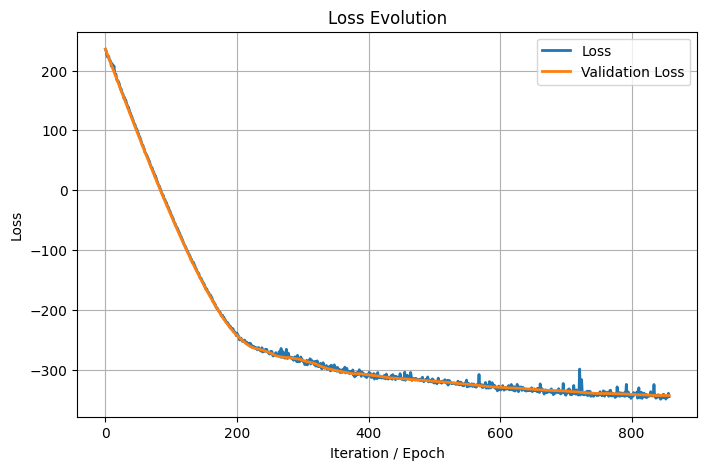

In [10]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.3273e+00,  1.3628e+00,  1.3214e+00,  1.2923e+00,  1.2987e+00,
         2.0403e+00,  8.5410e-01,  2.3437e-01,  5.9284e-01,  2.7282e+00,
         1.6411e+00,  1.6411e+00, -8.7440e+00,  1.1450e+00,  1.1953e+00,
         1.1386e+00,  1.1567e+00,  1.3751e+00,  3.0795e-01,  2.7618e-01,
         2.1940e+00,  1.6411e+00,  1.6411e+00,  1.6411e+00,  9.2828e-03,
         1.4676e-02,  1.3678e-02, -1.8679e-02,  5.9723e-02,  4.1238e-02,
         9.1247e-02,  6.0112e-02,  1.2036e-01,  1.9122e-01, -1.9772e-01,
         1.3001e-03,  3.9225e-01,  1.4803e-01,  2.2757e-01,  3.8324e-01,
         1.8139e-01, -2.5713e-04, -1.2888e-01, -3.9710e-01, -5.6843e-01,
         1.0415e+00,  5.5756e-01,  2.4126e-01,  2.7261e-01,  3.5827e-01,
         4.5100e-01,  2.8112e-01,  1.2415e-01,  3.3324e-01, -3.9989e-02,
        -7.8491e-02, -1.6361e-01, -6.8933e-02, -9.2191e-02,  2.7671e-01,
         1.1973e-01, -4.9631e-02, -3.2801e-02, -3.9343e-02, -4.7278e-02,
         2.8347e-02, -2.9092e-03,  9.2741e-

In [12]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [13]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [14]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.3832
KLD Gaussian Train Data:  0.1024
KLD Copula   Train Data:  -0.001
KLD GTM      Test  Data:  1.3613
KLD Gaussian Test  Data:  0.1079
KLD Copula   Test  Data:  0.0037


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

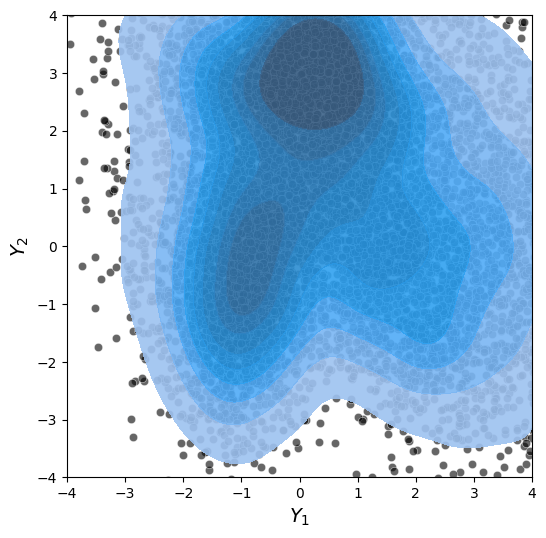

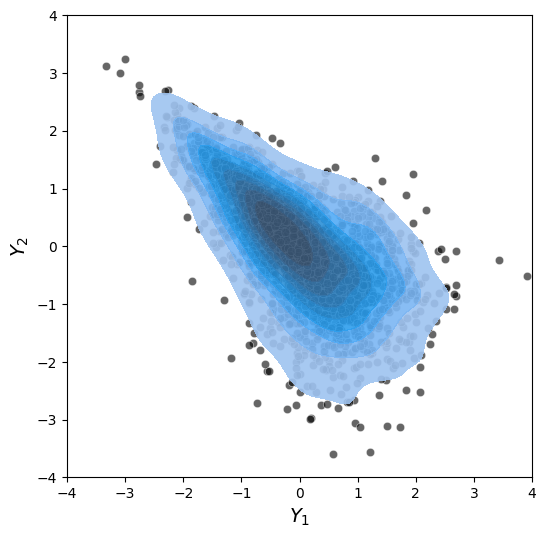

In [19]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


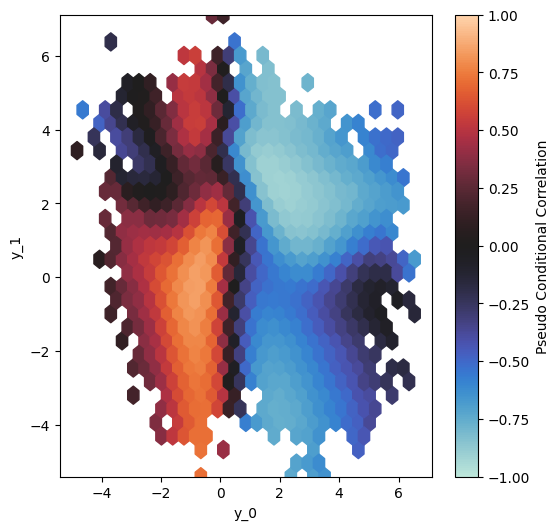

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


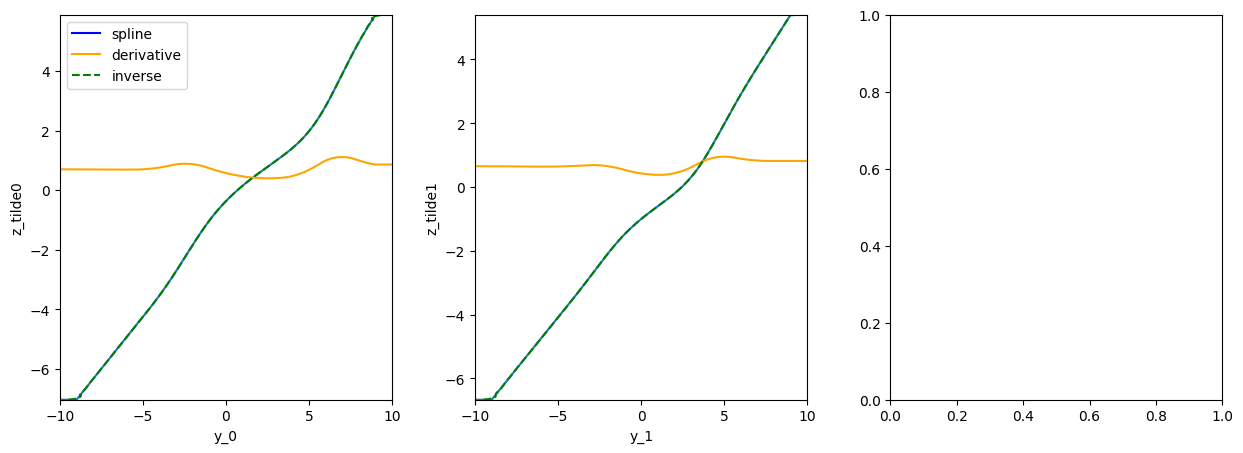

In [22]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


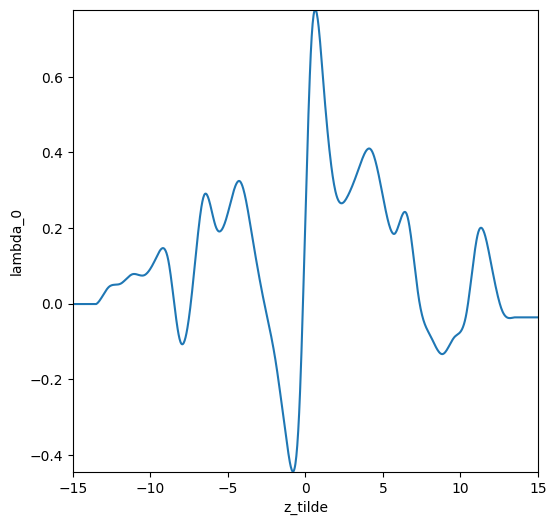

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


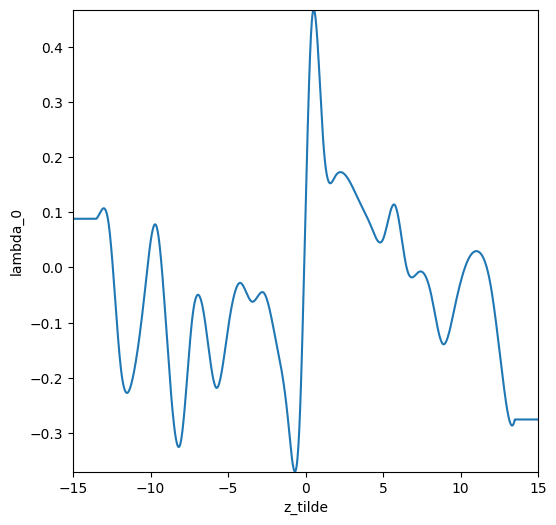

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


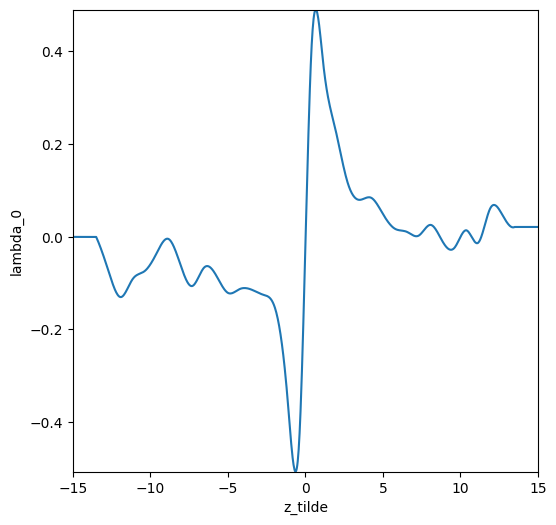

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)